# Introdução

&ensp; Neste notebook, serão apresentados cinco modelos de agrupamento. Esses modelos serão os candidatos à resolução da dor da Unipar de identificar os perfis de saúde de seus colaboradores. Trata-se de cinco diferentes algoritmos de agrupamento (K-Means, Gaussian Mixture, DBSCAN, Affinity Propagation e Spectral Clustering) que terão seus hiperparâmetros refinados com o uso de Grid Search ou Random Search para se tornarem os modelos mais adequados possível para este problema de segmentação.

&ensp; Ao final deste notebook esses modelos serão comparados com base em:
1. Adequação ao problema: Qualitativa
2. *Calinski-Harabasz Index*: Quantitativa
3. *Davies-Bouldin Index*: Quantitativa
4. *Silhouette Score*: Quantitativa

&ensp; Então, ao fim deste notebook, o melhor modelo será eleito para a utilização final no UniData.


## Importação de Bibliotecas

In [ ]:
import pandas as pd  # Importa a biblioteca Pandas para manipulação e análise de dados.
import numpy as np  # Importa a biblioteca NumPy para operações numéricas e manipulação de arrays.
import plotly.express as px  # Importa Plotly Express para visualização interativa de dados.
import matplotlib.pyplot as plt  # Importa Matplotlib para criação de gráficos estáticos.
from sklearn.metrics import make_scorer, silhouette_score, calinski_harabasz_score, davies_bouldin_score  # Importa métricas de avaliação para modelos de clustering.
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV  # Importa ferramentas para divisão de dados e busca de hiperparâmetros.
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # Importa métodos para codificação de rótulos e normalização de dados.
from sklearn.manifold import TSNE  # Importa t-SNE para redução de dimensionalidade.

## Funções

&ensp; Nesta seção, serão definidas funções reutilizáveis que facilitam a avaliação e análise dos modelos de agrupamento ao longo do notebook. Essas funções foram projetadas para simplificar o processo de avaliação, permitindo a obtenção de resultados de maneira eficiente e consistente.

&ensp; Abaixo está a função `avaliar_agrupamento()`, ela é responsável por avaliar a qualidade do agrupamento utilizando diferentes métricas. Ela aceita os dados, os rótulos gerados pelo modelo e o nome do algoritmo utilizado como parâmetros. Os resultados incluem o Silhouette Score, o Índice de Davies-Bouldin e o Índice de Calinski-Harabasz, que fornecem uma visão abrangente da performance do agrupamento.

In [2]:
def avaliar_agrupamento(X, rotulos, algoritmo):
    """
    Avalia a qualidade do agrupamento utilizando diferentes métricas.

    Args:
        X: Os dados utilizados para o agrupamento.
        rotulos: Os rótulos gerados pelo modelo.
        algoritmo: O nome do algoritmo de agrupamento utilizado.
    """
    # Calcula as métricas de avaliação
    silhueta = silhouette_score(X, rotulos)  # Score de Silhouette
    davies_bouldin = davies_bouldin_score(X, rotulos)  # Índice de Davies-Bouldin
    calinski_harabasz = calinski_harabasz_score(X, rotulos)  # Índice de Calinski-Harabasz

    # Exibe os resultados de forma formatada
    print("------------------------------------------------")
    print(f"Resultados para {algoritmo}:")
    print(f"Silhouette Score: {silhueta:.4f}")
    print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Index: {calinski_harabasz:.4f}")
    print("------------------------------------------------")

**Função de Avaliação com Silhouette Score**

&ensp; A função `avaliador_silhouette()` é utilizada neste notebook para calcular o Silhouette Score de modelos de agrupamento durante o processo de hiperparametrização. Essa função permite avaliar a qualidade dos agrupamentos de maneira eficiente e pode ser integrada, por exemplo, ao Randomized Search para otimização de hiperparâmetros, proporcionando uma métrica personalizada que orienta a seleção das melhores configurações para o modelo.

In [3]:
# Define a função de avaliação utilizando o Silhouette Score
def avaliador_silhouette(estimator, X):
    """
    Calcula o Silhouette Score para um modelo de agrupamento.

    Args:
        estimator: O modelo de agrupamento a ser avaliado.
        X: Os dados para avaliação.

    Returns:
        O Silhouette Score, ou -1 se todos os pontos estão no mesmo cluster.
    """
    rotulos = estimator.fit_predict(X)  # Aplica o modelo e obtém os rótulos
    if len(set(rotulos)) > 1:  # Verifica se há mais de um cluster
        return silhouette_score(X, rotulos)  # Retorna o Silhouette Score
    else:
        return -1  # Retorna -1 se todos os pontos estão no mesmo cluster

## Preparação da Base

&ensp; Nesta etapa, será importada a base de dados obtida do notebook da segunda sprint do projeto. Esta base já passou por um processo de limpeza, onde dados irrelevantes ou inconsistentes foram removidos ou ajustados. A base utilizada aqui é a versão pós-limpeza e antes da aplicação de padronizações ou codificações mais complexas, como o One Hot Encoding, pois é necessário evitar problemas de alta dimensionalidade e sobreposição de escalonamento neste momento.

&ensp; O objetivo atual é realizar o processamento necessário para comparar diferentes modelos de aprendizagem não supervisionada sem interferir no processamento já realizado. Por isso, é fundamental realizar novos processamentos de forma controlada, preservando a integridade dos dados limpos.

In [ ]:
# Carregar a base de dados limpa do CSV
bd_limpo = pd.read_csv('bd_cleaned.csv', decimal=',')

# Exibir a estrutura do dataframe para verificar as colunas e tipos de dados
bd_limpo.info()

&ensp; Na saída acima está a estrutura de dados inicial, composta por 100463 entradas e 19 colunas. Essa estrutura será utilizada nas etapas subsequentes, onde é necessário selecionar as variáveis relevantes.

&ensp; Com a base de dados carregada, o próximo passo é selecionar as variáveis mais relevantes para os modelos. Aqui será escolhida *features* que forneçam informações importantes sobre os sinistros dos colaboradores, como empresa (hospitais), elegibilidade (titular ou dependente), sexo, faixa etária, tipo do plano e categoria, além do valor pago pelo sinistro.

&ensp; Estas variáveis foram cuidadosamente escolhidas para que possamos obter uma visão clara do perfil dos colaboradores e de seus sinistros, sem adicionar ruído desnecessário ao modelo.

In [ ]:
# Seleção das colunas mais relevantes para os modelos de aprendizado
variaveis_selecionadas = ['nome_empresa_sinistro', 'elegibilidade_sinistro', 'sexo_colaborador_sinistro', 'faixa_etaria_colaborador_sinistro', 'descricao_plano_sinistro', 'categoria', 'valor_pago_sinistro']

# Criar um novo dataframe com essas variáveis selecionadas
df_selecionada = bd_limpo[variaveis_selecionadas]

# Exibir a estrutura do novo dataframe para confirmar a seleção das variáveis
df_selecionada.info()

&ensp; Agora a estrutura da base foi reduzida para as variáveis mais importantes e das 19 *features* iniciais, mantiveram-se 7. É possível notar também que todas colunas estão com valores do tipo categórico (texto). Para que os algoritmos possam trabalhar adequadamente, é necessário converter as variáveis categóricas em números. Isso será feito utilizando o LabelEncoder, uma técnica simples que converte cada categoria em um número inteiro.

&ensp; Além disso, a variável valor_pago_sinistro, que é numérica, será tratada para garantir que está no formato correto.

In [ ]:
# Instanciar o LabelEncoder para converter as variáveis categóricas em números inteiros
label_encoder = LabelEncoder()

# Criar um novo dataframe para armazenar os dados processados
df_processada = pd.DataFrame()

# Aplicar o LabelEncoder em cada variável categórica selecionada
for coluna in ['nome_empresa_sinistro', 'elegibilidade_sinistro', 'sexo_colaborador_sinistro', 'faixa_etaria_colaborador_sinistro', 'descricao_plano_sinistro', 'categoria']:
    df_processada[coluna] = label_encoder.fit_transform(df_selecionada[coluna])

# Converter a coluna 'valor_pago_sinistro' para valores inteiros após converter para float
df_processada['valor_pago_sinistro'] = pd.to_numeric(df_selecionada['valor_pago_sinistro'])

# Exibir a contagem de valores únicos e os valores mínimo e máximo do dataframe processado
print("\nContagem de Valores Únicos por Coluna:")
print(df_processada.nunique())

print("\nValores Mínimos:")
print(df_processada.min())

print("\nValores Máximos:")
print(df_processada.max())


&ensp; Ao finalizar a codificação, é notório que as variáveis categóricas foram convertidas em números inteiros com sucesso, como mostrado acima. Agora, as colunas estão prontas para serem escalonadas para que todas as variáveis fiquem dentro de uma mesma faixa de valores. Isso é importante para que modelos de *machine learning* que dependem da distância entre os pontos, como K-Means, possam funcionar corretamente.

&ensp; Será utilizado o MinMaxScaler, que transforma os dados para o intervalo entre 0 e 1, mantendo a proporcionalidade entre os valores.

In [ ]:
# Instanciar o MinMaxScaler para normalizar os dados entre 0 e 1
scaler = MinMaxScaler()

# Aplicar o escalonamento em todas as colunas do dataframe processado
df_escalonada = pd.DataFrame(scaler.fit_transform(df_processada), columns=df_processada.columns)

# Exibir a contagem de valores únicos e os valores mínimo e máximo do dataframe escalonado
print("\nContagem de Valores Únicos por Coluna:")
print(df_escalonada.nunique())

print("\nValores Mínimos:")
print(df_escalonada.min())

print("\nValores Máximos:")
print(df_escalonada.max())

&ensp; Com o escalonamento concluído, as variáveis estão agora no intervalo entre 0 e 1, garantindo que os modelos de aprendizado de máquina, como o K-Means, possam trabalhar corretamente. Foram gerados três *dataframes*:

- `df_selecionada`: contém as variáveis selecionadas, sem modificações.
- `df_processada`: contém as variáveis categóricas já codificadas e o valor_pago_sinistro ajustado.
- `df_escalonada`: contém as variáveis processadas e escalonadas, prontas para serem usadas nos modelos de *machine learning*.

&ensp; A base de referência que será usada para treinar e comparar os modelos é o `df_escalonada`, pois ela contém os dados finalizados com o escalonamento necessário. No entanto, caso novos *dataframes* precisem ser gerados durante a exploração dos modelos, eles podem ser criados a partir de qualquer um desses três dataframes, desde que a comparação final entre os modelos seja feita utilizando a base escalonada (`df_escalonada`).

# Métricas

&ensp; Em processos de aprendizado não supervisionado e agrupamento, a qualidade dos *clusters* gerados pode ser avaliada por diferentes métricas. Estas se dividem em dois grupos: métricas de validação externa, quando há informações externas para avaliar a qualidade dos resultados de agrupamento, semelhante à análise de modelos de classificação; e as de validação interna, que são utilizadas quando não há informações externas disponíveis para auxiliar na análise de desempenho (SILVA et al., 2020). Um exemplo comum de métrica de validação externa em algoritmos de classificação é a acurácia, pois ela independe do funcionamento interno do modelo. Se os rótulos verdadeiros não forem conhecidos, a avaliação deve ser realizada usando o próprio modelo (SCIKIT LEARN, 2024). No contexto do projeto com a Unipar, como não se tem as classes dos dados, foram selecionadas métricas de validação interna para medir o desempenho dos agrupamentos, sendo elas: Coeficiente de Silhueta, Índice de Calinski-Harabasz e Índice de Davies-Bouldin.

&ensp; O Coeficiente de Silhueta é uma métrica que avalia a densidade e separação dos *clusters* gerados, variando de -1 a 1. Quanto mais próximo de 1, melhor a coesão interna dos *clusters* e a separação entre eles. Pontuações em torno de zero indicam *clusters* sobrepostos. Este coeficiente é calculado considerando duas medidas: a distância média entre um ponto e os outros dentro do mesmo cluster (coesão) e a distância entre um ponto e os membros do *cluster* mais próximo (separação). Uma vantagem do coeficiente de Silhueta é que ele funciona bem para *clusters* convexos e proporciona uma visão intuitiva da qualidade do agrupamento. Por outro lado, pode não ser ideal para outros conceitos de *clusters*, como os gerados por algoritmos baseados em densidade, como o DBSCAN.

&ensp; O Índice de Calinski-Harabasz, também conhecido como Critério de Razão de Variância, mede a relação entre a dispersão entre *clusters* e a dispersão dentro dos *clusters*. Quanto maior o valor do índice, mais bem definidos estão os *clusters* (MEDIUM, 2023). Uma das principais vantagens dessa métrica é a rapidez no cálculo, sendo uma das escolhas mais usadas para algoritmos que lidam com grandes volumes de dados. Contudo, assim como o coeficiente de Silhueta, o Índice de Calinski-Harabasz tende a favorecer *clusters* convexos e pode não capturar bem a qualidade de *clusters* irregulares ou com densidade variável.

&ensp; Uma terceira métrica é o Índice de Davies-Bouldin, que mede a similaridade entre os grupos, comparando a distância entre *clusters* com o tamanho dos próprios *clusters*. Zero é a menor pontuação possível e os valores ideais para a métrica são os mais próximos dele. Baseado unicamente em quantidades e características inerentes ao conjunto de dados, a simplicidade do cálculo e o uso apenas de distâncias pontuais são pontos positivos do Davies-Bouldin, além de ser aplicável em diferentes formas de *clusters*, inclusive para alguns gerados por algoritmos de densidade. Nesse caso, por exemplo, seria uma métrica útil para avaliar o DBSCAN. No entanto, o índice é sensível a outliers e tende a ser mais elevado em *clusters* convexos, o que pode limitar a sua eficácia em certos cenários (SCIKIT LEARN, 2024). Além disso, o uso de distâncias centróides restringe a métrica ao espaço euclidiano, não sendo ideal para todos os tipos de agrupamentos baseados em densidade.

&ensp; Dessa maneira, a combinação do Coeficiente de Silhueta, do Índice de Calinski-Harabasz e do Índice de Davies-Bouldin permite uma avaliação completa dos cinco algoritmos de agrupamento. Cada métrica adiciona uma perspectiva diferente à análise, garantindo uma comparação adequada da performance dos algoritmos de *clustering* escolhidos.

&ensp; Ao fim dessa comparação, será feita também uma avaliação qualitativa. Nesse sentido, os modelos serão avaliados quanto à capacidade de se traduzirem em conclusões úteis para o parceiro. Para tanto, gráficos de correlação entre as *features* dos modelos serão utilizados para que seja possível extrair informações acerca dos perfis dos colaboradores Unipar. Definidas as métricas de comparação, cada um dos modelos será aprimorados, por meio de algoritmos de otimização de hiperparâmetros adequados.

# Algoritmos para Otimização de Hiperparâmetros

&ensp; Hiperparâmetros, em aprendizado de máquina, são os parâmetros inicializados antes do treino de um modelo. Diferente dos parâmetros que são definidos com base no treinamento, como o *weight* de uma variável, os hiperparâmetros são definidos com base na escolha do grupo de trabalho. Nesse sentido, nota-se a significativa importância que esses aspectos têm para o modelo de aprendizagem, dado que eles “governam todo o processo de treinamento” (RAGHAV, 2018).

&ensp; Dada a importância desses parâmetros e a natureza empírica do trabalho com *machine learning*, a qual requer constantes testes, elaborou-se algoritmos de otimização para eles. Entre os algoritmos implementados pela biblioteca * estão *Randomized Search*, *Grid Search* e métodos com *Halving*. Ademais, outras bibliotecas como o * implementam outros métodos, como o *Bayes Search*.

&ensp; Esses algoritmos funcionam testando o modelo para diversas combinações de hiperparâmetros. Para cada combinação, o modelo testa *samples* do banco de dados e, então, ranqueia a combinação, com base na média da métrica pré-definida, como o *Silhouette Score* ou o *Calinski-Harabasz Score*, das *samples*. Esta é a base da maioria dos algoritmos de otimização.

&ensp; Neste projeto, utilizam-se o *Randomized Search* e o *Grid Search*. Não obstante terem a mesma base, a diferença entre eles está no número de configurações testadas dentro dos valores possíveis de hiperparâmetros. Enquanto no *Randomized Search* escolhe-se a quantidade máxima de configurações que o modelo deve testar, no *Grid Search*, também chamado de *Exhaustive Grid Search*, o algoritmo gera exaustivamente as configurações dentro dos valores possíveis de hiperparâmetros. Consequentemente, o tempo de processamento dos dois algoritmos é díspar, porém o próprio *Scikit Learn* admite que a diferença entre os seus resultados não é drástica (SCIKIT LEARN, [s.d.]).

&ensp; Deste modo, após testar os dois algoritmos, se não houver grande diferença entre os dois resultados, a SGESP preferirá utilizar o *Random Search*. Abaixo está a utilização desses algoritmos com diferentes métricas e para os cinco modelos escolhidos.

# Modelos

&ensp; Para realizar o agrupamento dos dados de sinistros dos planos de saúde dos colaboradores da Unipar, foram escolhidos diversos algoritmos de agrupamento com características distintas entre si, visando a obtenção de diferentes perspectivas e comportamentos dos dados. A escolha dos algoritmos: K-Means, DBSCAN, Affinity Propagation, Spectral Clustering e Gaussian Mixture, foi guiada pela necessidade de explorar o espaço de solução de maneira ampla, dado que cada técnica possui suposições, abordagens e maneiras de lidar com diferentes formas e densidades dos dados.

&ensp; O objetivo central foi evitar a sobreposição de resultados que ocorreria ao selecionar algoritmos com características semelhantes. Por exemplo, modelos como K-Means e Gaussian Mixture, embora possam exibir semelhanças em certos aspectos, possuem pressupostos muito distintos em relação à forma dos *clusters* e à distribuição dos dados. Enquanto o K-Means tende a identificar agrupamentos esféricos, o Gaussian Mixture trabalha com a suposição de que os dados seguem uma distribuição gaussiana. Já os métodos DBSCAN e Affinity Propagation diferem-se radicalmente, tanto na forma como lidam com ruídos e *outliers*, quanto na não necessidade de definir um número prévio de *clusters*. Isso permite que tais algoritmos sejam capazes de revelar estruturas complexas nos dados que os modelos mais tradicionais não capturam adequadamente.

<div align="center">
  <sub>Figura Y - Comparação entre os Diferentes Modelos de Clusterização</sub>

  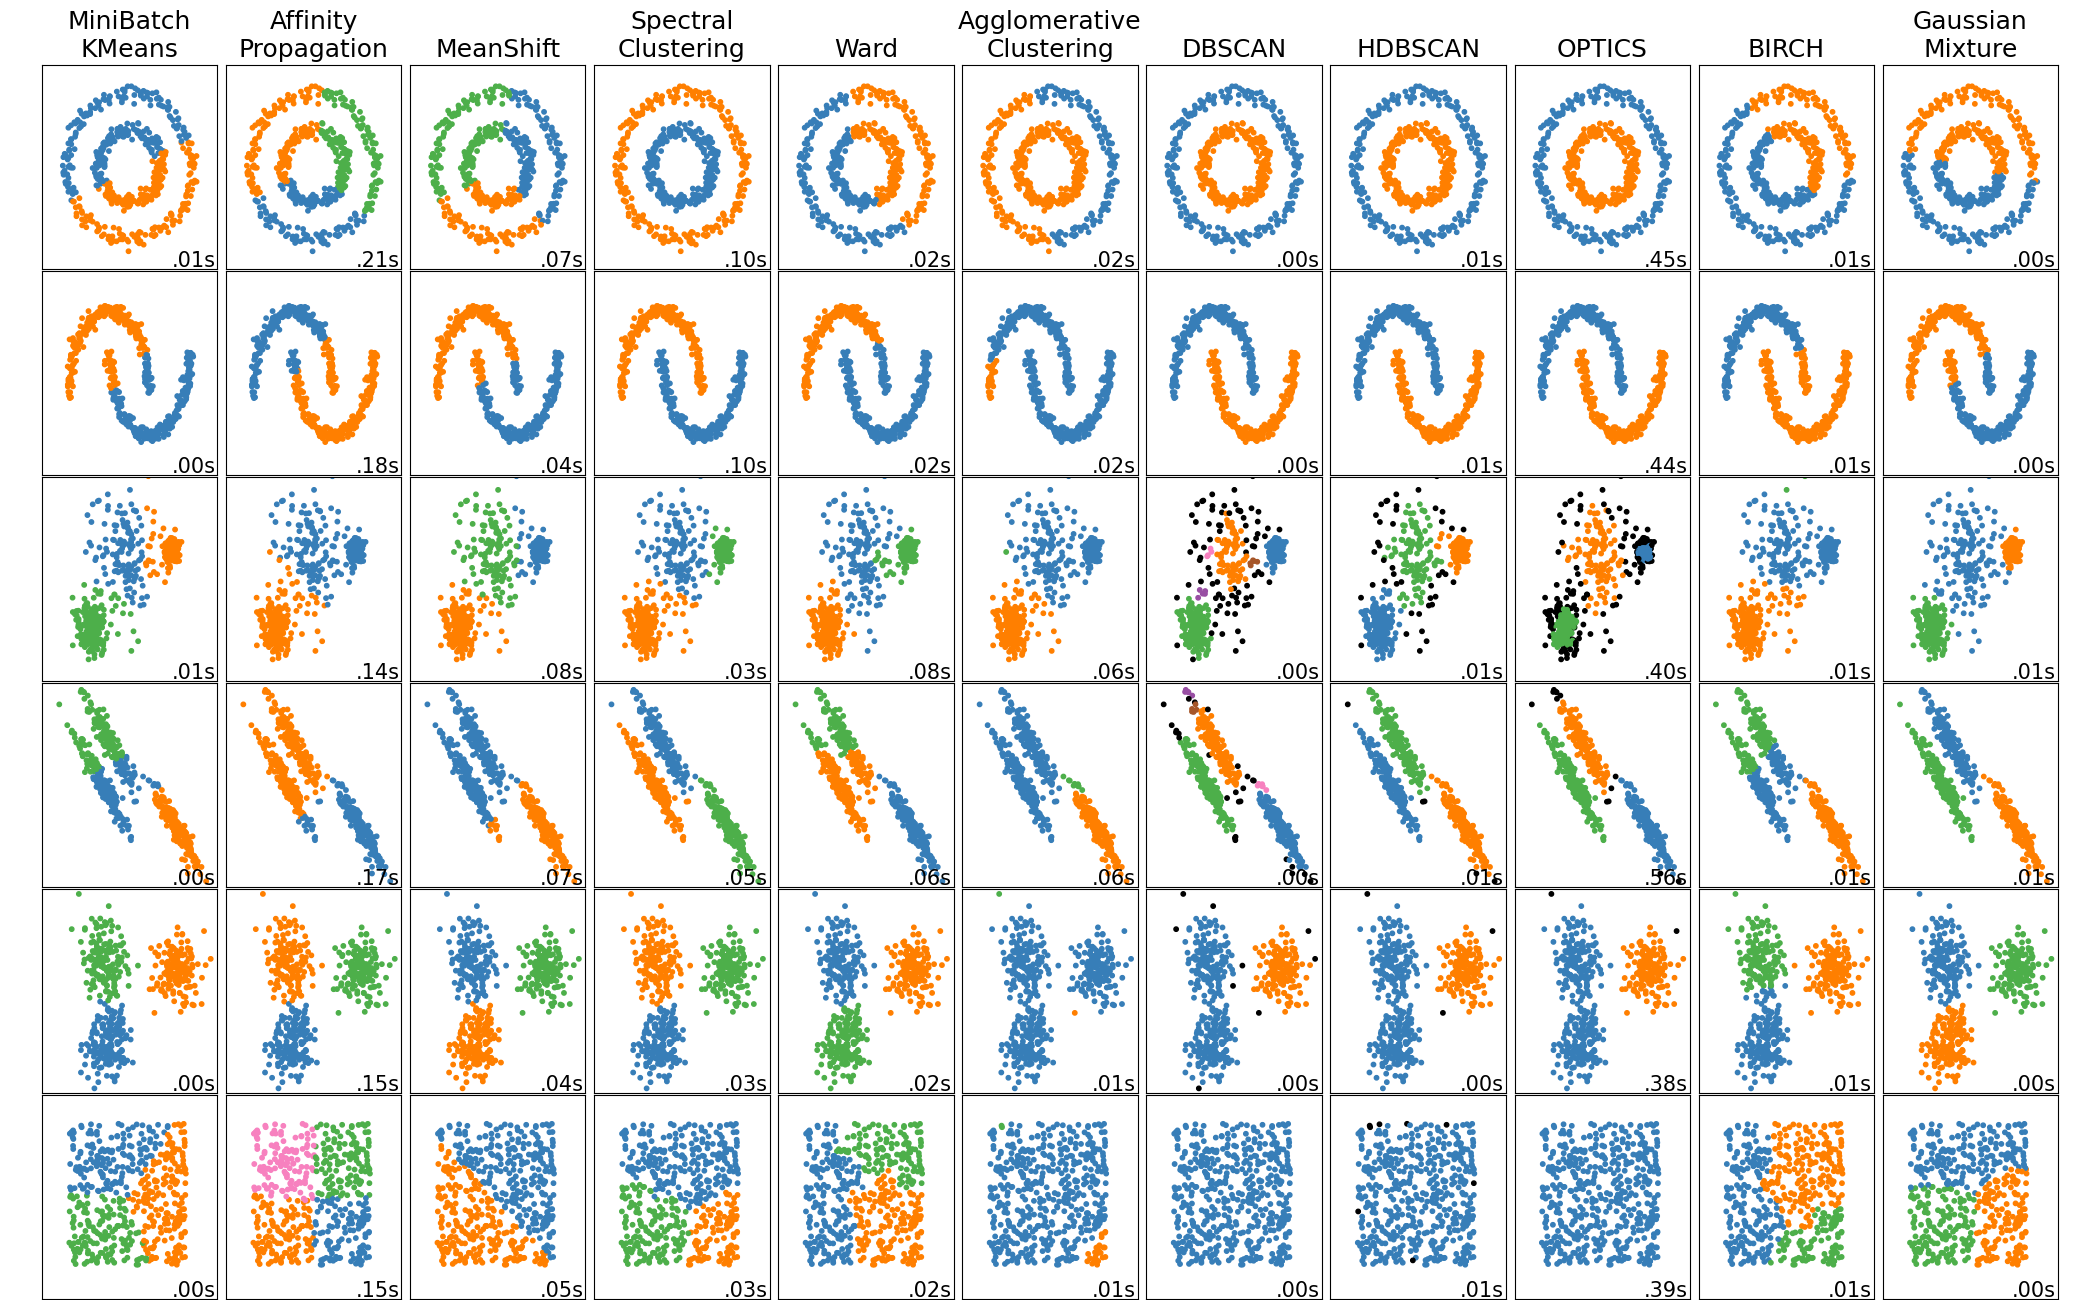
  
  <sup>Fonte: SCIKIT LEARN [s.d.].</sup>
</div>

&ensp; A diversidade dos métodos selecionados é ainda mais evidente quando observamos o comportamento de cada algoritmo sobre diferentes tipos de distribuição de dados, conforme ilustrado na imagem acima, fornecida pela documentação do *Scikit Learn*. Nessa imagem, cada algoritmo responde de maneira única a diferentes padrões de distribuição e densidade dos dados, destacando suas particularidades no processo de agrupamento. Esta distinção visual reforça a motivação para a escolha de modelos que são capazes de explorar diferentes formas de organização dos dados, seja através de *clusters* de tamanhos variados, padrões não lineares ou a capacidade de ignorar ruídos.

&ensp; Portanto, ao considerar a aplicação de múltiplos algoritmos de agrupamento, foram priorizadas abordagens que, de fato, oferecem diferentes representações dos dados, permitindo uma análise comparativa entre os resultados e, adicionalmente, uma maior profundidade no entendimento do perfil de saúde dos colaboradores da Unipar.


In [15]:
# Definindo uma constante para a semente aleatória
SEED_ALEATORIA = 42

## K-means

In [ ]:
from sklearn.cluster import KMeans  # Importa o algoritmo K-Means da biblioteca sklearn

&ensp;O K-means é um dos algoritmos de clusterização mais utilizados na análise de dados. Ele trabalha definindo um valor, um exemplo de dado, ou medida/característica principal para cada *cluster* (a letra K do nome faz referência aos ‘k’ *clusters*). Para cada dado ou objeto a ser classificado, é calculada a distância desse novo dado para o valor base central de cada *cluster*. O novo dado será agrupado ao *cluster* que estiver mais próximo das características desse novo dado (MEDIUM, 2020).

&ensp;Nas sprints passadas, o K-means já foi explicado e trabalhado para que o primeiro modelo proposto pelo grupo fosse realizado, sendo assim, o foco desta seção é realizar um *tuning* combinando diferentes hiperparâmetros a fim de obter o melhor resultado possível, ou seja, alterar não só apenas o `K`, como "init", "max_iter" e outros.

### Otimização de Hiperparâmetros do K-means

&ensp; Para alcançar o melhor agrupamento possível utilizando o modelo K-means, é fundamental identificar a combinação ideal de hiperparâmetros. Abaixo, é listado os principais hiperparâmetros que influenciam o processo de agrupamento. O parâmetro `n_clusters` é essencial, pois define o número de grupos a serem formados e, por isso, deve ser ajustado para refletir a estrutura dos dados. O `init` controla o método de inicialização dos centróides, afetando a qualidade dos agrupamentos iniciais e a convergência do modelo. O `max_iter` define o número máximo de iterações para garantir que o algoritmo tenha tempo suficiente para convergir. Já o `n_init` especifica quantas vezes o K-means será executado com diferentes inicializações, permitindo selecionar a melhor solução de agrupamento e reduzir a influência de inicializações ruins.

&ensp;  O Grid Search utiliza automaticamente a métrica de inércia (ou soma das distâncias quadráticas dos pontos aos seus centróides) como critério para avaliar a qualidade dos agrupamentos quando o algoritmo é o K-means. A inércia mede o quão próximos estão os pontos dos seus centróides e, assim, ajuda a determinar a configuração que resulta em um agrupamento mais coeso. Este algoritmo foi escolhido por abranger todas as configurações definidas. Embora sua demanda computacional seja alta, os testes mostraram que isso não foi um problema significativo, permitindo sua utilização eficaz neste contexto com o K-means.

In [ ]:
# Definindo uma constante para a semente aleatória
SEED_ALEATORIA = 42

# Cria uma instância do modelo K-Means
kmeans = KMeans(random_state=SEED_ALEATORIA)

# Definindo a grade de parâmetros para o Grid Search
grade_parametros_kmeans = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9],  # Diferentes valores de K para testar
    'init': ['k-means++', 'random'],  # Métodos de inicialização dos centróides
    'max_iter': [100, 300, 500],  # Número máximo de iterações para o algoritmo
    'n_init': [10, 20, 30]  # Número de vezes que o algoritmo é executado com diferentes centróides iniciais
}

# Utilizando o Grid Search para ajuste dos hiperparâmetros
grid_search_kmeans = GridSearchCV(kmeans, grade_parametros_kmeans, cv=5)  # cv é o número de folds na validação cruzada
grid_search_kmeans.fit(df_escalonada)  # Ajusta o modelo aos dados escalonados

# Exibe os melhores parâmetros encontrados
print("Melhores parâmetros encontrados: ", grid_search_kmeans.best_params_)

&ensp;O Grid Search então testa, no código acima, todas as combinações possíveis desses hiperparâmetros usando validação cruzada com 5 divisões (cv=5). A validação cruzada é uma técnica que divide o conjunto de dados em várias partes (ou "folds"), permitindo que o modelo seja treinado em algumas dessas partes e testado em outras. Isso garante que o melhor conjunto de parâmetros seja escolhido com base na performance do modelo em diferentes subconjuntos dos dados. Depois de treinar o modelo com cada combinação, o código imprime os melhores hiperparâmetros encontrados.


### Treinamento

&ensp; Abaixo, será feito o treinamento de um modelo utilizando a melhor combinação de hiperparâmetros encontrados através do Grid Search na seção superior.

&ensp;Os melhores parâmetros encontrados foram:

- **init**: 'k-means++' (método de inicialização avançado que otimiza o processo de escolha dos centróides),
- **max_iter**: 100 (número máximo de iterações),
- **n_clusters**: 9 (número de clusters que melhor segmenta os dados),
- **n_init**: 20 (o algoritmo será rodado 20 vezes com diferentes inicializações).

In [ ]:
# Criando o KMeans com os melhores parâmetros encontrados
modelo_final_kmeans = KMeans(
    n_clusters=grid_search_kmeans.best_params_['n_clusters'],  # Número ideal de clusters
    init=grid_search_kmeans.best_params_['init'],  # Método de inicialização
    max_iter=grid_search_kmeans.best_params_['max_iter'],  # Número máximo de iterações
    n_init=grid_search_kmeans.best_params_['n_init'],  # Número de inicializações
    random_state=SEED_ALEATORIA  # Para reprodutibilidade
)


modelo_final_kmeans.fit(df_escalonada)  # Ajusta o modelo aos dados

### Avaliação do Modelo

&ensp; &ensp; Nesta etapa, é necessário avaliar a qualidade do agrupamento obtido. Para isso, foram utilizadas as seguintes métricas de avaliação pré-estabelecidas: **Silhouette Score**, **Índice de Davies-Bouldin** e **Índice de Calinski-Harabasz**, que fornecem diferentes perspectivas sobre a eficácia do modelo.

In [ ]:
# Obter os rótulos do modelo K-Means treinado
rotulos_kmeans = modelo_final_kmeans.predict(df_escalonada)  # Prediz os rótulos para os dados escalonados

# Avaliando o K-Means
avaliar_agrupamento(df_escalonada, rotulos_kmeans, "K-Means")  # Avalia o agrupamento



&ensp; A avaliação do modelo K-Means treinado gerou os seguintes resultados:
- *Silhouette Score*: 0.3757
- *Davies-Bouldin Index*: 1.1783
- *Calinski-Harabasz Index*: 31350.4988

&ensp; Os valores indicam que o modelo foi capaz de identificar *clusters* razoavelmente distintos nos dados. O *Silhouette Score* de 0.3757 sugere uma separação ruim entre os grupos, enquanto o *Davies-Bouldin Index* de 1.1783 reforça que a compactação e separação dos *clusters* estão adequadas. O alto valor do *Calinski-Harabasz Index* também aponta para uma boa diferenciação entre os grupos, sinalizando que o modelo foi dedicado na tentativa de segmentar os perfis de utilização do convênio da empresa.

&ensp; A fim de realizar avaliar o último aspecto pré-estabelecido para as avaliações do modelo: o quanto os *clusters* dizem a respeito sobre os perfis de saúde da Unipar, foi gerada uma matriz de gráficos de dispersão (*Pair Plot*) para observar o comportamento das variáveis em relação umas às outras. Esse tipo de matriz permite visualizar as interações entre as diferentes variáveis, facilitando a identificação de possíveis padrões de agrupamento entre os dados. Ao representar as combinações de pares de variáveis em gráficos de dispersão, é possível verificar se os pontos se organizam de forma a formar grupos distintos, ou seja, se as variáveis contribuíram para a formação de *clusters* bem definidos.

In [ ]:
df_clusters_kmeans = df_escalonada.copy() # Cria uma cópia da base original
df_clusters_kmeans.loc[:, 'Cluster'] = rotulos_kmeans # Adiciona ao dataframe cópia da base original uma coluna com o valor de qual cluster pertence cada linha

# Cria um gráfico de matriz de dispersão usando a biblioteca Plotly Express
matriz_dispersao_kmeans = px.scatter_matrix(
    df_clusters_kmeans,  # DataFrame que contém os dados para o gráfico
    title='Matriz de Gráficos de Dispersão',  # Título do gráfico
    dimensions=['nome_empresa_sinistro', 'elegibilidade_sinistro', 'sexo_colaborador_sinistro', 'faixa_etaria_colaborador_sinistro', 'descricao_plano_sinistro', 'categoria', 'valor_pago_sinistro'],  # Colunas do DataFrame que serão usadas para criar os gráficos de dispersão
    color='Cluster',  # Coluna que será usada para colorir os pontos, indicando o cluster a que pertencem
    width=1200, # Largura do gráfico em pixels
    height=1200,  # Altura do gráfico em pixels
)

# Exibe o gráfico na tela
matriz_dispersao_kmeans.show()

&ensp;Com a matriz de dispersão, pode-se observar uma distribuição predominantemente homogênea entre as várias relações de *features*. Não há uma separação muito clara de *clusters* em muitas das combinações, sugerindo que o agrupamento pode não ter identificado padrões extremamente definidos para algumas relações.

&ensp;Uma observação relevante é que há uma tendência de que alguns *clusters* se concentram em determinados nomes de empresas, enquanto outros *clusters* estão ausentes nessas empresas. Isso pode indicar que a *feature* "nome da empresa" desempenhou um papel importante no agrupamento, influenciando o comportamento dos *clusters*. O gráfico também sugere que *clusters* específicos (como o *cluster* 8) podem estar mais concentrados em faixas etárias mais jovens, o que pode indicar uma correlação entre idade e alguns aspectos que levaram ao agrupamento.

&ensp;No gráfico entre "valor pago sinistro" e "nome da empresa", há uma clara separação por *clusters*, o que indica que algumas empresas podem estar associadas a sinistros de valores mais altos ou mais baixos. Por exemplo, o *cluster* 8 aparenta estar concentrado em empresas específicas com sinistros de valores maiores, enquanto os grupos 1, 2 e 3 parecem estar associados a sinistros de valores menores e também estão concentrados em empresas específicas.

&ensp;Novamente para o *cluster* 8, que está mais concentrado em planos específicos, a "descrição do plano" parece ser um fator de separação importante, indicando diferenças nas coberturas entre os grupos de colaboradores. Por outro lado, o grupo 5 apresenta uma distribuição mais dispersa no gráfico, com uma variação maior de "descrição do plano", o que sugere os membros desse *cluster* estão distribuídos entre diferentes tipos de cobertura.

&ensp;Já no eixo "categoria" e "nome da empresa", alguns *clusters* dominam categorias, o que pode indicar que certas empresas estão mais propensas a ter sinistros em categorias específicas e estar relacionado ao perfil de saúde dos colaboradores ou aos planos de saúde. O *cluster* 4 retrata um grupo concentrado em determinadas categorias de sinistro, por exemplo.

&ensp;Fora algumas correlações observadas, como a relação entre empresa e *clusters*, não parece haver evidências claras de que o agrupamento tenha identificado padrões visuais significativos para outras combinações de *features*. Isso sugere que o algoritmo K-Means pode não ter capturado muitos dos padrões subjacentes em alguns dos dados ou que outras *features* podem ser mais determinantes.

&ensp;Dessa forma, destaca-se a importância de explorar e treinar novos modelos. como DBSCAN, Gaussian Mixture, entre outras possibilidades, para que seja possível encontrar o modelo com os hiperparâmetros, algoritmo e resultados mais adequados ao que é necessário para o objetivo do projeto.

## DBSCAN

In [16]:
from sklearn.cluster import DBSCAN  # Importa o modelo de agrupamento DBSCAN

&ensp;Após o K-means, o DBSCAN (*Density-Based Spatial Clustering of Applications with Noise*) é o algoritmo de clusterização mais comum (MIRANDA, 2024). Essa técnica define os *clusters* de acordo com a densidade dos dados, formando grupos de maneira arbitrária e identificando *outliers*, diferentemente do K-means, que realiza esse agrupamento de forma esférica (AWAN, 2022).

### Otimização de Hiperparâmetros do DBSCAN

&ensp;Para que o agrupamento seja feito, são informados dois parâmetros:

- **eps (*Epsilon*)**: Este é o raio das distâncias entre os vizinhos. Se a distância entre dois pontos for menor ou igual a eps, eles serão considerados vizinhos.
- **min_samples (*Minimum Samples*)**: É o número mínimo de pontos de dados em uma determinada vizinhança para formar os agrupamentos.

&ensp;Estes serão os parâmetros utilizados na hiperparametrização, e o algoritmo escolhido foi o RandomizedSearchCV por ser uma abordagem mais viável, já que exige menos poder computacional em comparação ao Grid Search. Testes prévios indicaram que o tempo de processamento com o Grid Search era demasiadamente longo, tornando o Randomized Search a melhor opção.

&ensp;A fim de evitar o uso excessivo de memória durante a hiperparametrização, a base foi fracionada, e o número de dados utilizados corresponde a 35%, conforme a linha de código `X_train_sampled = X_train.sample(frac=0.35, random_state=42)`. Essa fração não foi escolhida aleatoriamente, pois várias alternativas foram testadas até que o ambiente do Colab não se sobrecarregasse, e 35% foi uma escolha adequada.

&ensp;Tanto no método Grid Search quanto no Random Search, é necessário definir um intervalo para os parâmetros que o algoritmo irá testar. Para o eps, são necessários testes prévios, pois, neste momento, ainda não é possível estimar se os dados estão muito densos ou não. Um intervalo geralmente utilizado é de 0.1 a 10, abrangendo desde dados muito próximos até dados mais separados. No entanto, como já foi identificado na sprint 3, os dados geralmente não estão muito próximos, por isso foi determinado um intervalo mais adequado ao projeto, entre 0.5 e 5. Já para o min_samples, devido às análises em sprints anteriores, já se tem conhecimento prévio sobre o que seriam bons agrupamentos. O intervalo decidido foi de 100 a 5000. Embora seja possível utilizar um intervalo maior, isso exigiria muito processamento, e o requisito mínimo do grupo foi que cada *cluster* possuísse pelo menos 100 dados (ERFAN, 2023).

&ensp;Além dos parâmetros, no Random Search é necessário também informar a pontuação (*scoring*) e o número de iterações que o algoritmo deve utilizar. A pontuação escolhida foi o *silhouette score*, pois essa métrica tende a ser mais precisa por utilizar diferentes aspectos para pontuar, e o número de iterações (n_iter) escolhido foi 50, já que serão realizados mais ajustes para otimização dos parâmetros.


In [17]:
# Instancia o DBSCAN
modelo_dbscan = DBSCAN()

In [ ]:
# Fraciona o banco de dados para 35% para treinamento
X_treino = df_escalonada.sample(frac=0.35, random_state=SEED_ALEATORIA)  # Seleciona 35% dos dados aleatoriamente

# Define os parâmetros para o RandomizedSearch
grade_parametros_dbscan = {
    'eps': np.linspace(0.5, 5, 10),  # Intervalo de valores para eps
    'min_samples': np.arange(100, 5000, 100)  # Intervalo de valores para min_samples
}

# Instancia o DBSCAN
modelo_dbscan = DBSCAN()  # Cria a instância do modelo DBSCAN

# Instancia o RandomizedSearchCV com os parâmetros definidos
random_search = RandomizedSearchCV(
    modelo_dbscan,  # Modelo a ser otimizado
    grade_parametros_dbscan,  # Parâmetros a serem testados
    n_iter=50,  # Número de combinações de parâmetros a serem exploradas
    scoring=avaliador_silhouette,  # Função de avaliação
    cv=5,  # Número de folds para validação cruzada
    verbose=1,  # Nível de detalhes nos logs
    n_jobs=1,  # Número de jobs paralelos
    return_train_score=True,  # Retorna também as pontuações de treinamento
    random_state=SEED_ALEATORIA  # Define a seed para garantir reprodutibilidade
)

# Executa a busca pelos melhores hiperparâmetros
random_search.fit(X_treino)

# Obtém os 5 melhores parâmetros encontrados
indices_top = np.argsort(random_search.cv_results_['mean_test_score'])[-5:]  # Indices dos 5 melhores
print("Top 5 combinações de parâmetros:")
for i in indices_top[::-1]:  # Itera sobre os índices dos melhores resultados
    print(f"Parâmetros: {random_search.cv_results_['params'][i]}, "
          f"Pontuação: {random_search.cv_results_['mean_test_score'][i]:.4f}")


&ensp;Nos hiperparâmetros mencionados acima, foram utilizados intervalos muito amplos. Foi possível identificar que entre min_samples = 700, eps = 0.8 e min_samples = 3100, eps = 1.2, as pontuações foram maiores que 0. Assim, um segundo teste foi realizado, utilizando um intervalo mais eficiente e testando mais valores.

In [ ]:
# Define novos parâmetros para uma busca mais refinada
grade_parametros_dbscan_refinada = {
    'eps': np.linspace(0.8, 1.3, 10),  # Intervalo de valores para eps refinado
    'min_samples': np.arange(100, 3100, 10)  # Intervalo de valores para min_samples refinado
}

# Instancia o RandomizedSearchCV novamente com os novos parâmetros
random_search_dbscan = RandomizedSearchCV(
    modelo_dbscan,  # Modelo a ser otimizado
    grade_parametros_dbscan_refinada,  # Parâmetros a serem testados
    n_iter=100,  # Número de combinações de parâmetros a serem exploradas
    scoring=avaliador_silhouette,  # Função de avaliação
    cv=5,  # Número de folds para validação cruzada
    verbose=1,  # Nível de detalhes nos logs
    n_jobs=1,  # Número de jobs paralelos
    return_train_score=True,  # Retorna também as pontuações de treinamento
    random_state=SEED_ALEATORIA  # Define a seed para garantir reprodutibilidade
)

# Executa a busca pelos melhores hiperparâmetros refinados
random_search_dbscan.fit(X_treino)

# Obtém os 5 melhores parâmetros encontrados
indices_top_refinados = np.argsort(random_search_dbscan.cv_results_['mean_test_score'])[-5:]  # Indices dos 5 melhores
print("Top 5 combinações de parâmetros refinadas:")
for i in indices_top_refinados[::-1]:  # Itera sobre os índices dos melhores resultados
    print(f"Parâmetros: {random_search_dbscan.cv_results_['params'][i]}, "
          f"Pontuação: {random_search_dbscan.cv_results_['mean_test_score'][i]:.4f}")

### Treinamento

&ensp;Na seção anterior, através do Random Search, foi descoberto que a melhor combinação para o modelo foi: `'min_samples': 180, 'eps': 0.9666666666666667`. Então aplicando estes valores visando o melhor treinamento do DBSCAN é obtido:

In [50]:
# Aplica o modelo DBSCAN com os melhores parâmetros encontrados
X_treino = df_escalonada.copy()
modelo_dbscan_final = DBSCAN(eps=0.96, min_samples=180).fit(X_treino)  # Treina o modelo com os parâmetros otimizados
df_clusters_DBSCAN = X_treino.copy()  # Cria uma cópia dos dados de treinamento
df_clusters_DBSCAN.loc[:, 'cluster'] = modelo_dbscan_final.labels_  # Adiciona os rótulos de cluster ao DataFrame

&ensp;Após o treinamento, foram obtidos 8 *clusters*.

### Avaliação do Modelo

&ensp;Com a clusterização feita, é possivel avaliar a pontuação do modelo com base utilizando as métricas já pré-estabelecidas.

In [ ]:
# Avalia o modelo DBSCAN utilizando a função definida
avaliar_agrupamento(X_treino, modelo_dbscan_final.labels_, "DBSCAN") # Esta função foi criada na seção do K-means

- Silhouette Score `0.4175`: Com um valor de 0.4175, os *clusters* parecem moderadamente separados, mas há algum grau de sobreposição ou ineficiência no agrupamento.

- Calinski-Harabasz Index `11753.5953`: Um valor alto como 11753 sugere que há uma boa separação entre os *clusters*, com os pontos dentro dos grupos relativamente compactos.

- Davies-Bouldin Index `1.0675`: O valor de 1.0675 está relativamente próximo de 1, o que significa que os *clusters* estão razoavelmente bem separados, mas ainda pode haver alguma similaridade entre eles.

&ensp;Mesmo com os resultados das métricas quantitativas, para uma análise mais profunda e holística, é importante visualizar gráficos que mostrem a distribuição dos grupos entre as *features* para uma análise qualitativa.

In [51]:
df = df_clusters_DBSCAN

In [ ]:
# Cria um gráfico de matriz de dispersão
matriz_dispersao_dbscan = px.scatter_matrix(
    df_clusters_DBSCAN,  # DataFrame que contém os dados para o gráfico
    title='Matriz de Gráficos de Dispersão',  # Título do gráfico
    dimensions=['nome_empresa_sinistro', 'elegibilidade_sinistro', 'sexo_colaborador_sinistro',
                'faixa_etaria_colaborador_sinistro', 'descricao_plano_sinistro', 'categoria',
                'valor_pago_sinistro'],  # Colunas do DataFrame a serem usadas para criar os gráficos de dispersão
    color='cluster',  # Coluna usada para colorir os pontos, indicando o cluster a que pertencem
    height=1800,  # Altura do gráfico em pixels
)

# Exibe o gráfico na tela
matriz_dispersao_dbscan.show()  # Mostra o gráfico

&ensp; Analisando o *Pair Plot* para uma avaliação qualitativa da distribuição dos *clusters* entre diferentes relações de *features* na base de dados treinada, observa-se uma distribuição predominantemente homogênea. No entanto, algumas correlações se destacam. Na relação entre as colunas `valor_pago_sinistro` e `nome_empresa_sinistro`, os *clusters* superiores se concentram exclusivamente na empresa UNIPAR CARBOCLORO S.A., enquanto os *clusters* inferiores estão restritos à empresa UNIPAR INDUPA DO BRASIL S.A. Esse padrão se repete em todas as relações envolvendo a coluna que indica o nome da empresa, sugerindo que essa *feature* desempenhou um papel importante no agrupamento dos dados. Além disso, nota-se que grande parte do *cluster* 8 está concentrada na faixa etária mais jovem, até 18 anos. Fora esses *insights*, não há evidências visuais claras de que o agrupamento tenha identificado padrões significativos que aprofundem o entendimento sobre o perfil de saúde dos colaboradores.

## Spectral Clustering

In [ ]:
from sklearn.cluster import SpectralClustering  # Importa o algoritmo de agrupamento Spectral Clustering

&ensp;O Spectral Clustering é uma técnica de agrupamento utilizada em aprendizado não supervisionado de máquina, especialmente para lidar com conjuntos de dados complexos e não lineares que métodos tradicionais, como o K-Means, não conseguem segmentar adequadamente. Ele é particularmente eficaz quando os dados apresentam padrões intrincados e quando a distribuição dos *clusters* não segue uma forma regular, como esferas ou elipses, exigindo uma abordagem mais robusta para identificar essas estruturas (LUXBURG, 2007).

&ensp;O processo do Spectral Clustering envolve várias etapas, que o tornam único em comparação com outras abordagens. Ele começa construindo uma matriz de similaridade entre os dados, onde cada ponto é conectado a outros pontos com base em sua semelhança. Essa etapa é como criar uma rede onde os nós representam os dados, e as conexões entre eles representam o quanto esses dados estão relacionados. Essa matriz de similaridade pode ser obtida por meio de métricas de distância, como a distância euclidiana ou o coeficiente de correlação (GUPTA, 2021).

&ensp;Depois de construir a matriz de similaridade, o próximo passo é formar a matriz Laplaciana, que é uma transformação da matriz de similaridade. A matriz Laplaciana leva em consideração tanto as similaridades quanto às relações globais entre os dados, ou seja, ela não olha apenas para vizinhos próximos, mas considera a estrutura global da "rede de amizades" entre os pontos de dados. A matriz Laplaciana destaca as conexões mais fortes, permitindo separar regiões de dados de forma eficaz.

&ensp;Uma vez construída a matriz Laplaciana, o algoritmo realiza uma decomposição espectral, que é o núcleo do Spectral Clustering. Esse processo envolve a aplicação de técnicas de álgebra linear, como a análise de autovalores e autovetores, para decompor a matriz e transformar os dados em um espaço onde os padrões de agrupamento se tornem mais fáceis de visualizar. Autovalores e autovetores essencialmente indicam a direção e magnitude das variações dentro dos dados, o que permite a identificação de fronteiras naturais entre *clusters* (CUBER GUIMARÃES; KONG, 2021).

&ensp;Após a decomposição espectral, o algoritmo mapeia os dados em um novo espaço de baixa dimensionalidade, mantendo as características principais da estrutura dos dados. Nesse novo espaço, o Spectral Clustering aplica um método de agrupamento convencional, como o K-Means, para finalmente agrupar os dados. Essa etapa final garante que os grupos formados sejam coerentes com as relações complexas que existiam nos dados originais, mas que foram simplificadas pela decomposição espectral.

&ensp;O Spectral Clustering destaca-se pela sua capacidade de lidar com dados complexos e identificar padrões em cenários onde métodos convencionais podem falhar. No projeto da Unipar, essa técnica oferece uma abordagem eficaz para segmentar perfis de sinistros e segurados, especialmente em situações onde as interações entre diferentes tipos de sinistros são mais complexas. Ao utilizar matrizes de similaridade e decomposição espectral, o Spectral Clustering permite uma análise mais detalhada, capturando nuances que contribuem para uma segmentação mais precisa e valiosa.

### Otimização de Hiperparâmetros do Spectral Clustering



&ensp;Para obter a melhor acrupamento com o Spectral Clustering, é necessário encontrar a melhor combinação de hiperparâmetros. No contexto deste modelo, os principais são:

1. `n_clusters:` número de *clusters* que o modelo formará. A escolha deste valor impacta diretamente a segmentação dos dados, onde valores inadequados podem gerar *clusters* muito grandes ou pequenos, prejudicando a análise.

2. `affinity`: define como a similaridade entre pontos é calculada. No contexto do projeto, será utilizado o `rbf`, que revela relações mais complexas, capturando semelhanças globais.

&ensp;Para otimizar esses hiperparâmetros de forma eficiente, em vez de usar o Grid Search, que testa todas as combinações possíveis e pode ser muito pesado, recomenda-se o uso do Randomized Search. Este método reduz o tempo de processamento testando combinações aleatórias de hiperparâmetros, sendo mais leve e eficiente, ainda mais com a utilização do Spectral Clustering, um modelo que demanda grandes recursos computacionais. A métrica utilizada no Randomized Search, similarmente à otimização do DBSCAN, será o *silhouette score*.




In [ ]:
# Amostrando 10% dos dados para treinamento
df_amostra = df_escalonada.sample(frac=0.1, random_state=SEED_ALEATORIA)

# Definindo o espaço de busca para os hiperparâmetros
grade_parametros_spectral = {
    'n_clusters': range(2, 11),  # Número de clusters variando de 2 a 10
    'affinity': ['rbf'],  # Usando apenas 'rbf' para maior conectividade
}

# Criando o modelo de Spectral Clustering
modelo_spectral_clustering = SpectralClustering()

# Configurando o RandomizedSearchCV
random_search_spectral = RandomizedSearchCV(
    estimator=modelo_spectral_clustering,
    param_distributions=grade_parametros_spectral,
    n_iter=9,  # Número de combinações aleatórias a testar
    scoring=avaliador_silhouette,  # Usando a função personalizada para calcular Silhouette Score
    cv=5,  # Validação cruzada com 5 divisões
    random_state=SEED_ALEATORIA,  # Para garantir reprodutibilidade
    n_jobs=1  # Para rodar em paralelo
)

# Ajustando o RandomizedSearchCV ao conjunto de dados amostrado
random_search_spectral.fit(df_amostra)

# Extraindo os melhores parâmetros e o melhor score
melhores_parametros_spectral = random_search_spectral.best_params_
melhor_pontuacao_spectral = random_search_spectral.best_score_

# Exibindo os resultados
print("Melhores Hiperparâmetros:", melhores_parametros_spectral)
print("Melhor Silhouette Score:", melhor_pontuacao_spectral)


### Treinamento

&ensp;Com os hiperparâmetros otimizados, o próximo passo é treinar o modelo utilizando o conjunto de dados preparado. O treinamento é realizado com o método **fit_predict()**, que ajusta o modelo aos dados e gera as previsões dos *clusters* simultaneamente. Isso permitirá que o algoritmo identifique os *clusters* com base nos parâmetros otimizados.

In [ ]:
# Instanciando o modelo de Spectral Clustering com os melhores hiperparâmetros
modelo_final_spectral = SpectralClustering(
    n_clusters=melhores_parametros_spectral['n_clusters'],  # Número de clusters definido pelos melhores parâmetros
    affinity=melhores_parametros_spectral['affinity'],  # Afinidade definida como RBF (Radial Basis Function)
    random_state=SEED_ALEATORIA  # Garantindo reprodutibilidade
)

# Treinando o modelo e gerando os rótulos de clusters
rotulos_clusters_spectral = modelo_final_spectral.fit_predict(df_amostra)

# Exibindo os rótulos dos clusters atribuídos aos dados
print("Rótulos dos Clusters:", rotulos_clusters_spectral)

&ensp;Após o treinamento do modelo de Spectral Clustering, os rótulos dos *clusters* atribuídos aos dados foram obtidos. O próximo passo é armazenar esses rótulos em um novo DataFrame, que incluirá tanto os dados originais quanto os rótulos dos *clusters*. Isso permitirá uma análise mais aprofundada dos resultados.


In [ ]:
# Criando um novo DataFrame com os dados amostrados
df_clusters_spectral = pd.DataFrame(df_amostra)  # Cria um novo DataFrame a partir do conjunto de dados amostrados

# Adicionando a coluna com os rótulos dos clusters
df_clusters_spectral['rótulo_cluster'] = rotulos_clusters_spectral  # Adiciona a coluna 'rótulo_cluster' ao DataFrame

# Exibindo as primeiras linhas do novo DataFrame
df_clusters_spectral.head()

&ensp; Na próximas etapas, a qualidade dos *clusters* será avaliada utilizando métricas apropriadas, como o índice de Davies-Bouldin e o índice de Calinski-Harabasz, visando comparar os resultados obtidos com outros modelos candidatos.

### Avaliação do Modelo

&ensp; Assim como nos modelos anteriores, é necessário avaliar os modelos para obter as métricas utilizadas. Para isso, os resultados também serão obtidos através da função `avaliar_agrupamento()`.

In [ ]:
# Avalia o agrupamento do Spectral Clustering utilizando a função definida
avaliar_agrupamento(df_amostra, rotulos_clusters_spectral, "Spectral Clustering")

&ensp;O valor calculado para o DBI (*davies bouldin index*) foi 1.1608, o que indica que os *clusters* não estão perfeitamente separados, mas ainda assim têm uma separação razoável. Um valor de 1.1608 sugere que há alguma sobreposição entre os grupos, ou seja, os grupos de funcionários podem ter características semelhantes em alguns aspectos. No entanto, este valor está relativamente próximo de 1, o que sugere que o agrupamento ainda conseguiu capturar perfis diferenciados.

&ensp;Com relação ao CHI (*calinski-harabasz index*), o valor obtido foi 3032.2036, o que é um valor baixo em relação aos outros testes. O *Silhouette Score* calculado para este modelo é de 0.3827. Esse valor sugere que os *clusters* formados apresentam uma separação ruim, embora ainda haja margem para melhorias. Um *Silhouette Score* entre 0.3 e 0.4 indica que os *clusters* não estão fortemente sobrepostos, mas a distinção entre eles poderia ser bem mais clara.

&ensp;Dessa forma, para uma análise qualitativa, tem-se a visualização em gráfico da distribuição dos grupos entre as *features*. A seguir, o Pair Plot é utilizado para avaliar o comportamente dos *clusters* com diferentes relações.

In [ ]:
# Cria um gráfico de matriz de dispersão
grafico_matriz_dispersao = px.scatter_matrix(
    df_clusters_spectral,  # DataFrame que contém os dados para o gráfico
    title='Matriz de Gráficos de Dispersão',  # Título do gráfico
    dimensions=['nome_empresa_sinistro', 'elegibilidade_sinistro', 'sexo_colaborador_sinistro',
                'faixa_etaria_colaborador_sinistro', 'descricao_plano_sinistro', 'categoria',
                'valor_pago_sinistro'],  # Colunas do DataFrame a serem usadas para criar os gráficos de dispersão
    color='rótulo_cluster',  # Coluna usada para colorir os pontos, indicando o cluster a que pertencem
    width=1200, # Largura do gráfico em pixels
    height=1200,  # Altura do gráfico em pixels
)

# Exibe o gráfico na tela
grafico_matriz_dispersao.show()  # Mostra o gráfico

&ensp;Analisando o Pair Plot para uma avaliação qualitativa da distribuição dos *clusters* entre as diferentes relações de *features*, pode-se identificar que o "valor_pago_sinistro" foi um fator de forte impacto na separação dos clusters, principalmente quando se relaciona "valor_pago_sinistro" com "categoria" ou com "nome_empresa_sinistro". No entanto, os grupos formados com base no nome da empresa ou na categoria de serviço médico não agregam muito valor, pois apenas reúnem informações relacionadas ao tipo de sinistro. O objetivo do projeto é identificar perfis de colaboradores, e não simplesmente agrupar doenças ou categorias de serviços médicos.

&ensp;Ainda, para uma análise mais profunda, é possível partir para a criação de outros gráficos de dispersão para visualizar os grupos formados. Será necessário fazer o uso da técnica de t-SNE (t-Distributed Stochastic Neighbor Embedding) para reduzir a dimensionalidade dos dados e visualizar *clusters* em um gráfico de dispersão bidimensional. Inicialmente, o t-SNE transforma os dados de alta dimensionalidade, armazenados em `df_amostra`, para um espaço com apenas duas dimensões, permitindo a visualização de como os pontos se distribuem em relação aos *clusters* gerados previamente.

&ensp;O código cria um *DataFrame* com essas novas dimensões e adiciona os rótulos dos *clusters*, que são plotados com cores distintas para cada grupo. Em seguida, um gráfico de dispersão é gerado, onde cada ponto representa um dado, e a posição dele no gráfico reflete a similaridade em relação a outros pontos, preservando as relações locais entre os dados originais. As duas dimensões geradas pelo t-SNE não têm um significado direto, mas indicam a proximidade relativa entre os dados, facilitando a interpretação dos grupos no espaço original.

In [ ]:
# Aplicando o t-SNE para redução de dimensionalidade
tsne = TSNE(n_components=2, random_state=SEED_ALEATORIA)
X_embutido = tsne.fit_transform(df_amostra)

# Criando um DataFrame para os dados reduzidos
df_tsne = pd.DataFrame(X_embutido, columns=['Dimensão 1', 'Dimensão 2'])
df_tsne['Cluster'] = rotulos_clusters_spectral  # Adicionando os rótulos dos clusters

# Criando uma lista de cores distintas para os clusters usando 'tab10'
cores = plt.colormaps.get_cmap('tab10')

# Visualizando os clusters com cores distintas
plt.figure(figsize=(10, 8))
for cluster in np.unique(df_tsne['Cluster']):
    dados_cluster = df_tsne[df_tsne['Cluster'] == cluster]
    plt.scatter(dados_cluster['Dimensão 1'], dados_cluster['Dimensão 2'],
                color=cores(cluster % 10),  # Usar o módulo para clusters > 10
                label=f'Cluster {cluster}', alpha=0.7)

# Adicionando título e rótulos dos eixos
plt.title('Visualização dos Clusters com t-SNE')
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')

# Adicionando legenda
plt.legend(title="Clusters", loc='best')

# Adicionando a grade
plt.grid()
plt.show()

&ensp;A visualização dos *clusters* no gráfico de dispersão mostra que os pontos estão bem distribuídos ao longo do espaço, refletindo a complexidade dos dados. No entanto, a análise revela que muitos grupos estão próximos uns dos outros, sugerindo que a separação entre alguns *clusters* não é suficientemente pronunciada. Isso pode indicar uma sobreposição entre alguns grupos, onde os pontos de diferentes *clusters* estão muito próximos, dificultando a identificação clara das fronteiras entre eles.

&ensp;Além disso, é notável que alguns pontos estão muito sobrepostos, resultando em uma densidade elevada em certas áreas do gráfico. Essa sobreposição pode ser um sinal de que as características desses pontos são semelhantes, ou que a escolha dos hiperparâmetros do modelo não capturou de maneira eficaz a estrutura subjacente dos dados. Portanto, o Spectral Clustering pode ser considerado um modelo ruim para este problema de segmentação.



## Affinity Propagation

In [ ]:
from sklearn.cluster import AffinityPropagation  # Importa o modelo Affinity Propagation

&ensp; O método de clusterização Affinity Propagation que identifica automaticamente a quantidade de agrupamentos de dados através da técnica "*message-passing*". Ou seja, o Affinity Propagation não requer a estipulação do número k de *clusters* a serem identificados no banco de dados (YENIGUN, 2023). Dessa forma, os dados comunicam sua "preferência" por ser um exemplar central ou um ponto de dados representativo (PERES, 2024).

&ensp; O Affinity Propagation baseia-se na troca de mensagens - técnica *message-passing* - entre os dados até que sejam encontrados exemplares que representam os *clusters* encontrados pelo algoritmo. As similaridades entre cada dado avaliado são inputados ao modelo, e a cada interação de agrupamento são passadas dois tipos de mensagens: responsabilidades e disponibilidades, calculadas através das características dos dados que compõem a avaliação (BRENDAN, DELBERT, 2019).

<div align="center">
  <sub>Figura Y - Clusterização do Affinity Propagation</sub>
  <img src="https://www.ritchievink.com/img/post-14-affinity_propagation/preference_subset.gif" alt="Affinity Propagation" border="0"> <br>
  <sup>Fonte: VINK, Ritchie (2018).</sup>
</div><br>

&ensp; Entende-se as matrizes utilizadas para o agrupamento via Affinity Propagation abaixo:

### **Matriz de Similiaridade**

&ensp;A matriz de similaridade é fundamental para completude do mecanismo "*message-passing*" do método *Affinity Propagation*. Esta matriz contém o valor negativo da distância média euclidiana entre dois pontos selecionados e é encontrada conforme cálculo abaixo.

<div align="center">
$∀ i,k : r(i,k) = S(i,k) - max[S(i,k') + a(i,k')]$
</div>

&ensp;Esta função garante que pontos mais próximos, em termos de distância, tenham alta similaridade, uma vez que retornarão valores negativos.


### **Matriz de Responsabilidade**

&ensp;A matriz de responsabilidade, denotada como *R*, quantifica quão adequado um ponto de dados *k* é para servir como um exemplar para outro ponto de dados *i*. Ela reflete a evidência acumulada do ponto de dados *i* em relação à adequação de *k* como seu exemplar, levando em conta as preferências de outros pontos de dados por *k*.
A regra de atualização para a matriz de responsabilidade é dada por:

<div align="center">
$r(i,k)=s(i,k) - max(a(i,k')+s(i,k'))$
</div>

Sendo que:

- $s(i,k)$ representa a similaridade entre os pontos $i$ e $k$;

- $a(i,k′)$ é a disponibilidade do ponto $k′$ para ser escolhido como um exemplar para o ponto $i$;

- $k'$ deve ser diferente $k$.

&ensp;Isso significa que a responsabilidade reflete quão melhor o ponto $k$ é em comparação com outros exemplares candidatos para o ponto $i$.

### **Matriz de Disponibilidade**

&ensp;A matriz de disponibilidade, denotada como A, indica quão apropriado é para o ponto de dados i escolher o ponto de dados k como seu exemplar. Ela considera não apenas a responsabilidade do ponto k, mas também quantos outros pontos o preferem como um exemplar.

&ensp;A regra de atualização para a matriz de disponibilidade segue dois casos:

#### **Sendo $i = k$**

&ensp;Em situações em que o ponto $i$ seja igual $k$, a fórmula de atualização da matriz de disponibilidade segue:

<div align="center">
$a(i,k)=\sum_{i'\neq k}max(0,r(i',k))$
</div>

#### **Sendo $i \neq k $**

&ensp;Em situações em que o ponto $i$ **não** seja igual $k$, a fórmula de atualização da matriz de disponibilidade segue:

<div align="center">
$a(i,k)=min(0,r(k,k)+\sum_{i'\neq i,k}max(0,r(i',k)))$
</div>

&ensp;Portanto, a matriz de disponibilidade explicíta a preferência de um ponto $k$ de ser seu próprio exemplar, além de compreender sua interação com outros pontos.

### **Exemplares**

&ensp; Os pontos destacados como exemplares são dados identificados como
centrais ou representantes do *cluster* em que faz parte. Após iterar por atualizações de responsabilidades e disponibilidades até a convergência, os exemplares são determinados com base nos valores finais nessas matrizes. Um ponto de dados é considerado um exemplar se a soma de sua responsabilidade e disponibilidade líquidas (ou seja, $r(i,i)+a(i,i)>0$) for positiva.

&ensp; Desta forma, os exemplares servem efetivamente como os centros em torno dos quais os *clusters* são formados. Ao contrário dos métodos tradicionais de agrupamento que calculam centróides, o Affinity Propagation identifica diretamente pontos de dados reais como exemplares.


### Otimização de Hiperparâmetros do Affinity Propagation

&ensp; No contexto do agrupamento de dados através do algoritmo Affinity Propagation, os hiperparâmetros satisfatórios foram encontrados a partir da comparação do desempenho do modelo a partir de diferentes parâmetros estabelecidos.

&ensp; Para _tuning_ do algoritmo, portanto, foi utilizado dois parâmetros principais:

- **preference**: representa a probabilidade de um dado se tornar um exemplar e, consequentemente, influencia diretamente na quantidade de *clusters* gerados pelo algoritmo (GEEKS, 2024).

- **damping**: define a velocidade de convergência do algoritmo (valores próximos de 1 indicam convergência mais lenta); influencia na precisão e estabilidade dos *clusters* gerados (GEEKS, 2024).

&ensp; Visto a complexidade do algoritmo e carga computacional exigida, fraciona-se 10% da base original `df_escalonada` para a otimização dos parâmetros supracitados. Para tal otimização, foi utilizado o método Random Search, como aplicado abaixo.

In [ ]:
# Amostra 10% da base de dados para teste
df_amostra = df_escalonada.sample(frac=0.10, random_state=SEED_ALEATORIA)

# Define os hiperparâmetros comuns utilizados na aplicação do Affinity Propagation
grade_parametros_affinity = {
    'preference': np.linspace(-50, 10, num=10),
    'damping': np.linspace(0.9, 0.95, num=5)
}

# Configura o Randomized Search com o modelo AffinityPropagation
random_search_affinity = RandomizedSearchCV(
    AffinityPropagation(),
    grade_parametros_affinity,
    n_iter=10,
    cv=5,
    scoring=avaliador_silhouette,
    verbose=1,
    n_jobs=-1,
    random_state=SEED_ALEATORIA  # Adicionando random_state para garantir reprodutibilidade
)

# Aplica o método .fit() no Random Search
random_search_affinity.fit(df_amostra)

# Exibe os melhores parâmetros encontrados após a aplicação do Random Search
print(f'Melhores parâmetros do Random Search: {random_search_affinity.best_params_}')
print(f'Melhores resultados do Random Search: {random_search_affinity.best_score_}')

&ensp;Em uma primeira otimização dos hiperparâmetros, os melhores valores encontrados para os parâmetros a partir deste método, configurado em 10 iterações sobre 5 validações cruzadas e gerando `50 fits`, são elencados abaixo:

- `preference`: -3.3333333333333286

- `damping`: 0.9

&ensp;Melhores resultados do Random Search: 0.5137909941046146

&ensp;No entanto, os resultados desta otimização levantaram uma configuração do algoritmo que não oferece resultados tão satisfatórios, em especial considerando o número de *clusters* gerados.

In [ ]:
# Instancia e treina o modelo de Affinity Propagation com os melhores parâmetros encontrados
modelo_affinity = AffinityPropagation(
    preference=random_search_affinity.best_params_['preference'],
    damping=random_search_affinity.best_params_['damping']
).fit(df_amostra)

# Obtém o número de clusters
print(f"Número de Clusters: {len(np.unique(modelo_affinity.labels_))}")

&ensp;Considerando o agrupamento de 93 *clusters*, conclui-se que o resultado do processo de clusterização a partir dos parâmetros encontrados na aplicação do _Random Search_ não auxilia efetivamente na identificação dos perfis de colaboradores da Unipar, além de que uma exploração individual destes *clusters* seria inviável.

&ensp;Portanto, partiu-se para uma estimativa manual em busca de um valor do parâmetro `preference`. Aqui, é importante destacar que um valor menor indica diminuição na quantidade de *clusters* gerados, sendo o inverso verdadeiro. Desta forma, diversos valores de `preference` foram testados manualmente em busca de um número satisfatório de agrupamentos.

&ensp;Decidiu-se, em conclusão, assumir o parâmetro de `preference = -450` para clusterização de nossa base de dados. Com este valor, o algoritmo Affinity Propagation gera 9 *clusters*

### Treinamento

&ensp; Após vários testes, os hiperparâmetros `preference = 450` e `damping = 0.9` foram identificados como os mais adequados, resultando em uma quantidade de grupos e métricas satisfatórias. Agora, o algoritmo será treinado com esses valores ajustados manualmente, sem o auxílio de algoritmos de otimização, embora esses tenham fornecido informações valiosas sobre o influência de cada combinação na formação dos *clusters*.

In [ ]:
# Aplica o Affinity Propagation com novos parâmetros
modelo_affinity_ajustado = AffinityPropagation(
    preference=-450,
    damping=0.9
).fit(df_amostra)

# Obtém o número de clusters para o novo treinamento
print(f"Número de Clusters: {len(np.unique(modelo_affinity_ajustado.labels_))}")

### Avaliação do Modelo

&ensp; A fim de aferir a eficácia do modelo modelo treinado com os melhores hiperparâmetros para o Affinity Propagation, submete-se o modelo treinado às metricas Silhouette Score, Davies-Bouldin e Calinski-Harabasz, como demonstrado abaixo.

In [ ]:
# Avaliando Affinity Propagation
avaliar_agrupamento(df_amostra, modelo_affinity_ajustado.labels_, "Affinity Propagation")

&ensp; Com os resultados obtidos através das métricas, observa-se alguns *insights* sobre a clusterização gerada:

- Silhouette Score: um valor de `0.3132` sugere que a separação entre os *clusters* não é ideal, visto que valores próximos a 0 indicam que os pontos estão muito próximos das bordas entre clusters. Valores próximos de 1 indicam boa separação, enquanto valores negativos indicam má atribuição.

- Davies-Bouldin Index: o valor `40.0220` encontrado indica que os *clusters* estão mal definidos, visto que o índice Davies-Bouldin mede a similaridade média entre cada *cluster* e o *cluster* mais semelhante a ele. Quanto menor o valor, melhor a separação entre os clusters.

- Calinski-Harabasz Index: sugere-se, com base no valor `40.2170` encontrado, que o algoritmo gerou uma clusterização com baixa qualidade, já que este índice indica a relação entre a dispersão entre os *clusters* e a dispersão interna dentro de cada *cluster*. Valores mais altos geralmente indicam uma melhor definição dos grupos, e um valor baixo indica que os *clusters* podem estar sobrepostos ou mal delineados.

&ensp; Tais métricas indicam que o algoritmo Affinity Propagation não gerou *clusters* de alta qualidade, o que dificulta a análise dos agrupamentos formados e indica sobreposição de dados. Entretanto, para análise qualitativa, gera-se _Pair Plot_ para investigação das relação entre as _features_ presentes em *d_frac* após a aplicação do Affinity Propagation.

In [ ]:
# Copia o DataFrame fracionado e adiciona a coluna com os labels de cluster
df_clusters_affinity = df_amostra.copy()
df_clusters_affinity['Cluster'] = modelo_affinity_ajustado.labels_

# Cria um gráfico de matriz de dispersão usando a biblioteca Plotly Express
matriz_dispersao_affiniy = px.scatter_matrix(
    df_clusters_affinity,  # DataFrame que contém os dados para o gráfico
    title='Matriz de Gráficos de Dispersão - Affinity Propagation',  # Título do gráfico
    dimensions=['nome_empresa_sinistro', 'elegibilidade_sinistro', 'sexo_colaborador_sinistro',
                'faixa_etaria_colaborador_sinistro', 'descricao_plano_sinistro', 'categoria',
                'valor_pago_sinistro'],  # Colunas do DataFrame que serão usadas para criar os gráficos de dispersão
    color='Cluster',  # Coluna que será usada para colorir os pontos, indicando o cluster a que pertencem
    height=1800,  # Altura do gráfico em pixels
    width=1800  # Largura do gráfico em pixels
)

# Exibe o gráfico na tela
matriz_dispersao_affiniy.show()

&ensp; Para análise do gráfico gerado, é importante destacar os valores de silhueta encontrados a partir da clusterização gerada. O valor de _Silhouette Score_ médio para os agrupamentos do Affinity Propagation é de `0.3132`, que indica baixa qualidade dos *clusters* gerados e dificulta a análise de relação entre as _features_.

&ensp; Analisando a distribuição dos dados nos *clusters* gerados, valida-se a hipótese levantada anteriormente com base no _score_ de silhueta encontrado, em que os agrupamentos não indicam correlações significativas para análise de perfil dos colaboradores da Unipar. Entretanto, é possível identificar destaque do *cluster* 6 no agrupamento de dados específicos da _feature_ `nome_empresa_sinistro`, que agrupa exclusivamente o valor de referência à 'UNIPAR CARBOCLORO S.A.', em contramão ao *cluster* de número 5, que concentra valores referentes a 'UNIPAR INDUPA DO BRASIL S.A.'.

&ensp; Ademais, a utilização do algoritmo de clusterização Affinity Propagation se mostra ineficaz para o agrupamento eficiente dos dados em nosso _dataset_, uma vez que, dado seu alto custo computacional e baixa qualidade dos *clusters* gerados, não fornece visualização eficiente das correlações entre _features_. Desta maneira, conclui-se que o modelo não contribui de maneira satisfatória para a identificação de perfis dos colaboradores da Unipar.

## Gaussian Mixture

In [8]:
from sklearn.mixture import GaussianMixture # Importa o modelo de agrupamento Gaussian Mixture

&ensp; O Gaussian Mixture Model (GMM) é um modelo probabilístico que supõe que os dados foram gerados a partir de uma combinação de várias distribuições Gaussianas com parâmetros desconhecidos. Ele generaliza o K-means ao incorporar a variabilidade dos dados, considerando a forma e a dispersão (covariância) dos grupos. O GMM utiliza o algoritmo de Expectation-Maximization (EM) para ajustar as distribuições aos dados, atribuindo probabilidades a cada ponto de pertencer a uma determinada Gaussiana.

&ensp; Além disso, o GMM permite diferentes configurações de covariância (esférica, diagonal, amarrada ou completa) para ajustar melhor a forma dos *clusters*. O Bayesian Information Criterion (BIC) é uma métrica utilizada para comparar modelos, penalizando aqueles que utilizam um maior número de parâmetros. Ele equilibra a qualidade do ajuste do modelo com a simplicidade, ajudando a determinar o número ideal de componentes. Isso torna o GMM útil tanto para segmentação quanto para estimativa de densidade.

### Otimização de Hiperparâmetros do Gaussian Misture

&ensp; Nesta abordagem, diferentes modelos GMM são ajustados variando o número de componentes (*clusters*). Para cada modelo, calcula-se o BIC, que ajuda a identificar o número adequado de grupos. A escolha final do número de *clusters* será aquela que minimiza o valor de BIC, já que essa métrica penaliza modelos mais complexos.

In [ ]:
# Definindo o intervalo de componentes
numero_componentes = range(1, 10)
valores_bic = []

# Calculando o BIC para cada número de componentes
for n in numero_componentes:
    modelo_gmm = GaussianMixture(n_components=n, random_state=2)
    modelo_gmm.fit(df_escalonada)
    valores_bic.append(modelo_gmm.bic(df_escalonada))

# Plotando os resultados do BIC
plt.plot(numero_componentes, valores_bic, marker='o')
plt.title('Valores BIC para Diferentes Números de Grupos')
plt.xlabel('Número de Componentes')
plt.ylabel('BIC')
plt.xticks(numero_componentes)
plt.show()

# Imprimindo o número ideal de clusters
numero_ideal_grupos = numero_componentes[np.argmin(valores_bic)]
print(f'O número ideal de clusters é: {numero_ideal_grupos}')

&ensp; Essa abordagem indica que o número ideal de *clusters* é 9, com base no Critério de Informação Bayesiano (BIC). Tendo feito isso, o próximo passo envolve a busca pela melhor combinação de hiperparâmetros no contexto do modelo Gaussian Mixture. Para isso, utiliza-se uma abordagem de Grid Search, que testa diferentes configurações de parâmetros, como o tipo de covariância e o nível de regularização, mantendo fixo o número de componentes previamente encontrado.

&ensp; Nesse processo, busca-se o modelo que minimiza o BIC, garantindo que os parâmetros escolhidos resultem no melhor ajuste possível aos dados.

In [ ]:
# Função personalizada para calcular o BIC
def calcular_bic(modelo, X):
    """Calcula o BIC para o modelo ajustado."""
    return modelo.bic(X)

# Hiperparâmetros para o Grid Search
grade_parametros_gmm = {
    'n_components': [numero_ideal_grupos],  # Número de componentes
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],  # Tipo de covariância
    'reg_covar': [1e-6, 1e-4, 1e-3, 1e-2]  # Regularização
}

# Definindo o modelo GMM
gmm_inicial = GaussianMixture(random_state=2)

# Configurando o GridSearchCV com BIC como métrica
grid_search_gmm = GridSearchCV(gmm_inicial, grade_parametros_gmm,
                              scoring=make_scorer(calcular_bic, greater_is_better=False),
                              n_jobs=-1, cv=5)

# Ajustando o modelo aos dados
grid_search_gmm.fit(df_escalonada)

# Extraindo o melhor modelo e seus hiperparâmetros
modelo_final_gmm = grid_search_gmm.best_estimator_

# Exibindo os melhores hiperparâmetros encontrados
print("Melhores Hiperparâmetros:")
print(grid_search_gmm.best_params_)

# Exibindo os valores de BIC e AIC para o melhor modelo
print(f"BIC: {modelo_final_gmm.bic(df_escalonada)}")
print(f"AIC: {modelo_final_gmm.aic(df_escalonada)}")

### Treinamento

&ensp; Encontrou-se, por meio do algoritmo de otimização de hiperparâmetros, que os melhores valores para este modelo, considerando a base de dados em questão, são: **{'covariance_type': 'full', 'n_components': 9, 'reg_covar': 1e-06}**. Com isso, procede-se ao treinamento do modelo utilizando esses parâmetros ajustados para garantir a melhor performance possível.

In [ ]:
# Treinando o modelo com os melhores hiperparâmetros encontrados
modelo_final_gmm.fit(df_escalonada)

# Copia o DataFrame original e adiciona a coluna com os labels de cluster
df_clusters_gmm = df_escalonada.copy()
df_clusters_gmm['cluster'] = modelo_final_gmm.predict(df_escalonada)

# Exibindo os primeiros resultados
df_clusters_gmm.head()

### Avaliação do Modelo

&ensp; Uma vez selecionado o melhor modelo, este é avaliado por meio de métricas de qualidade de agrupamento, como o Silhouette Coefficient, o Índice de Calinski-Harabasz e o Índice de Davies-Bouldin. Esses indicadores fornecem uma visão mais detalhada da coesão e separação dos *clusters* formados, auxiliando na validação do modelo.

&ensp; Assim, o método garante que a escolha final dos parâmetros não apenas respeite o número de *clusters* ideal, mas também maximize a qualidade do agrupamento gerado.

In [ ]:
# Avaliando o modelo Gaussian Mixture com as métricas definidas
avaliar_agrupamento(df_escalonada, modelo_final_gmm.predict(df_escalonada), "Gaussian Mixture")

&ensp;A análise realizada utilizando o modelo de Gaussian Mixture Model (GMM) revelou resultados relevantes na identificação de padrões nos dados. Através da otimização de hiperparâmetros com GridSearchCV, foi possível encontrar a configuração ideal que minimizou o BIC (Bayesian Information Criterion) e aprimorou a qualidade do ajuste do modelo.

&ensp;As métricas de avaliação do clustering trouxeram informações importantes sobre a eficácia do modelo:

- **Silhouette Score [0.2317]:** Este valor indica que os pontos não estão tão bem agrupados, sugerindo uma separação moderada entre os clusters.

- **Calinski-Harabasz Index [23851.9263]:** Um valor elevado nesta métrica sugere que os clusters são bem definidos e distantes uns dos outros.

- **Davies-Bouldin Index [1.7005]:** O valor obtido nesta métrica indica que a distância entre os clusters é maior em comparação com a dispersão interna deles, embora não seja um valor baixo.

&ensp;Apesar dos resultados medianos, é preciso avaliar o modelo qualitativamente


### Análise qualitativa

*Abaixo encontra-se uma célula que exporta o dataframe que será utilizado na aplicação UNIDATA (Streamlit).*

In [ ]:
bd_para_analise = bd_limpo.copy()

bd_para_analise['cluster'] = df_clusters_gmm['cluster'].copy()

bd_para_analise.to_csv("bd_para_analise.csv")

&ensp; O objetivo deste projeto é identificar perfis de saúde dos colaboradores Unipar. Portanto, o primeiro passo para a análise qualitativa é retirar os *clusters* subrepresentados, os quais por serem pequenos são incapazes de identificar um perfil. Para verificar isso, usa-se um boxplot com o método ``value_counts()`` no ``df_escalonada``.

In [ ]:
# Gráfico de caixas (boxplot) da contagem de clusters
px.box(x=df_clusters_gmm['cluster'].value_counts(), title="Distribuição de Clusters", labels={
    'x': 'Número de Ocorrências'
})

&ensp; Não obstante não haver _outliers_ neste boxplot, optou-se por retirar todos os grupos menores do que o 1º quartil. Sendo assim, ficaram de fora os *clusters* 4, 5 e 6.

In [15]:
# Filtra os clusters de interesse e cria um novo DataFrame para análise
bd_gaussian_analise = df_clusters_gmm.loc[~df_clusters_gmm['cluster'].isin([4, 5, 6])].copy()

&ensp; A partir de agora, o ``bd_gaussian_analise`` será usado para as análises dos perfis Unipar.

#### Correlação de variáveis

&ensp; Conforme feito para o primeiro modelo candidato (K-means com k=6), a etapa de análise começa com uma exploração da distribuição dos grupos entre as relações de variáveis. Para tanto, gera-se os seguintes gráficos de dispersão.

In [ ]:
# Cria um gráfico de matriz de dispersão
matriz_dispersão_gmm = px.scatter_matrix(
    bd_gaussian_analise,  # DataFrame que contém os dados para o gráfico
    title='Matriz de Gráficos de Dispersão para Gaussian Mixture',  # Título do gráfico
    dimensions=['categoria', 'valor_pago_sinistro', 'faixa_etaria_colaborador_sinistro', 'sexo_colaborador_sinistro','descricao_plano_sinistro'],  # Colunas do DataFrame que serão usadas para criar os gráficos de dispersão
    color='cluster',  # Coluna que será usada para colorir os pontos, indicando o cluster a que pertencem
    height=1200,  # Altura do gráfico em pixels
)

# Exibe o gráfico na tela
matriz_dispersão_gmm.show()

&ensp; A partir dessa matriz, observa-se dois resultados interessantes:
1. Como se observa na linha 2, coluna 3, o *cluster* 8 agrupou majoritariamente valores baixos e médios pagos por menores de 18 anos
2. Como se observa na linha 2, coluna 4, o *cluster* 7 agrupou a grande maioria das mulheres desde que as que pagaram os menores valores até os maiores.

&ensp; Entretanto, no caso da Gaussian Mixture, olhar as *features* independentemente pode ser mais produtivo já que não se retiram outros *insights* dessa matriz.

#### Separação por sexo


&ensp; Por ter menor grau de complexidade e pela segunda observação da correlação de variáveis, optou-se por estudar primeiro a distribuição dos *clusters* por sexo. Abaixo, pode-se verificar a criação de um histograma com distribuição dos *clusters* por sexo.

In [17]:
bd_gaussian_analise['categoria'] = bd_limpo['categoria']
bd_gaussian_analise['codigo_servico_sinistro'] = bd_limpo['codigo_servico_sinistro']

In [18]:
bd_gaussian_analise['segurado'] = bd_limpo['segurado'].copy()

# Criação de uma cópia explícita do DataFrame
df_grafico_sexo = bd_gaussian_analise.drop_duplicates(subset=['segurado', 'sexo_colaborador_sinistro'], keep='first').copy()

# Mapeia a coluna de sexo para valores legíveis
df_grafico_sexo['sexo_colaborador_sinistro'] = df_grafico_sexo['sexo_colaborador_sinistro'].replace({
    0: 'Feminino',
    1: 'Masculino'
})

In [ ]:
# Define a paleta de cores para os clusters
cores_clusters = [
    '#1E88E5',  # Azul Vibrante
    '#D32F2F',  # Vermelho Intenso
    '#388E3C',  # Verde Escuro
    '#FBC02D',  # Amarelo Brilhante
    '#8E24AA',  # Roxo Forte
    '#F57C00',  # Laranja Vivo
    '#1976D2',  # Azul Médio
    '#C2185B',  # Rosa Escuro
    '#7B1FA2'   # Roxo Médio
]

# Criação do histograma para a distribuição percentual de clusters por sexo
grafico_sexo = px.histogram(
    df_grafico_sexo,
    x='sexo_colaborador_sinistro',
    color='cluster',
    color_discrete_sequence=cores_clusters,  # Aplica a paleta de cores definida
    barmode='group',
    histnorm='percent',  # Normaliza as barras em porcentagem
    title='Distribuição Percentual de Clusters por Sexo de Segurado Único',  # Título do gráfico
    category_orders={'cluster': [0,1,2,3,7,8]}  # Ordem dos clusters no gráfico
)

# Personalização dos eixos
grafico_sexo.update_layout(
    xaxis_title='Sexo',  # Rótulo do eixo X
    yaxis_title='Porcentagem de Ocorrência(%)'  # Rótulo do eixo Y
)

# Exibe o gráfico
grafico_sexo.show()

&ensp; O histograma acima demonstra que o sexo foi um grande separador entre os cluster, sendo que os *clusters* 0, 2 e 7 representam apenas homens e os *clusters* 1, 3 e 8 representam apenas mulheres. Em relação, porém, a qual cluster representa melhor cada um dos sexos, faz-se a análise absoluta abaixo.

In [ ]:
# Criação do histograma para a contagem de ocorrências por sexo e cluster
grafico_contagem_sexo = px.histogram(
    df_grafico_sexo,
    x='sexo_colaborador_sinistro',
    color='cluster',
    color_discrete_sequence=cores_clusters,  # Aplica a paleta de cores definida
    barmode='group',
    title='Contagem de Ocorrências por Cluster por Sexo de Segurado Único',  # Título do gráfico
    category_orders={'cluster': list(range(9))}  # Ordem dos clusters no gráfico
)

# Personalização dos eixos
grafico_contagem_sexo.update_layout(
    xaxis_title='Sexo',  # Rótulo do eixo X
    yaxis_title='Contagem de Ocorrências'  # Rótulo do eixo Y
)

# Exibe o gráfico
grafico_contagem_sexo.show()

&ensp; Dessa forma, vê-se que o *cluster* 2 e o *cluster* 1 são os mais representativos entre os sexos feminino e masculino, respectivamente. Não obstante, a diferença deles para os outros *clusters* do mesmo sexo, com exceção do *cluster* 7 não é tão significativa.

#### Separação por Faixa Etária

&ensp; Após descoberta a separação por sexo de cada *cluster*, faz-se necessário descobrir a separação por faixa etária, sendo este o segundo e último dado demográfico do banco de dados fornecido pela Unipar. Abaixo, vê-se a distribuição dos *clusters* por faixa etária.

In [ ]:
# Criação de uma cópia do DataFrame para manipulação sem alterar o original
df_grafico_idade = bd_gaussian_analise.drop_duplicates(subset=['segurado', 'faixa_etaria_colaborador_sinistro'], keep='first').copy()

# Criação do mapeamento de valores únicos para faixas etárias
valores_unicos_idade = df_grafico_idade['faixa_etaria_colaborador_sinistro'].unique()
lista_valores_idade = bd_limpo['faixa_etaria_colaborador_sinistro'].unique()
mapeamento_faixa_etaria = dict(zip(valores_unicos_idade, lista_valores_idade))

# Aplicação do mapeamento de faixas etárias no DataFrame
df_grafico_idade['faixa_etaria_colaborador_sinistro'] = df_grafico_idade['faixa_etaria_colaborador_sinistro'].replace(mapeamento_faixa_etaria)

# Criação do histograma para a distribuição de clusters por faixa etária
grafico_contagem = px.histogram(
    df_grafico_idade,
    x='faixa_etaria_colaborador_sinistro',  # Coluna para o eixo X
    color='cluster',  # Coluna que define a cor das barras
    barmode='group',  # Exibe as barras agrupadas por cluster
    title='Distribuição de Clusters por Faixa Etária de Segurado Único',  # Título do gráfico
    color_discrete_sequence=cores_clusters,  # Aplica a paleta de cores definida
    histnorm='percent',  # Normaliza as barras em porcentagem
    category_orders={  # Define a ordem das categorias no eixo X e dos clusters
        'faixa_etaria_colaborador_sinistro': ['0 a 18 anos', '19 a 23 anos', '24 a 28 anos', '29 a 33 anos', '34 a 38 anos', '39 a 43 anos', '44 a 48 anos', '49 a 53 anos', '54 a 58 anos', '59 anos ou mais'],
        'cluster': list(range(9))  # Ordem dos clusters
    }
)

# Personalização dos eixos
grafico_contagem.update_layout(
    xaxis_title='Faixa Etária',  # Rótulo do eixo X
    yaxis_title='Porcentagem de Ocorrência(%)'  # Rótulo do eixo Y
)

# Exibe o gráfico
grafico_contagem.show()

&ensp; Neste caso, a primeira observação é a clara predominância de pessoas de 0 a 18 anos no *cluster* 8. Portanto, pode-se inferir que no *cluster* 8 predominam homens de 0 a 18 anos. Entre os homens, observa-se também que quase não há ocorrências entre os 19 e os 28 anos, dado que nenhum dos três *clusters* têm mais de 10% de distribuição nesta faixa de idade. Ademais, vê-se que o *cluster* 1 e 3 priorizaram homens mais velhos, sendo o *cluster* 1 feito de >30% de homens idosos e o *cluster* 3 com um pico entre 44 e 48 anos.

&ensp; Em relação a mulheres, esta análise é menos clara. Pode-se verificar que o *cluster* 7 não contém mulheres de 0 a 18 anos. Ademais, vê-se que o *cluster* 7 priorizou mulheres idosas e entre 34 a 38 anos. Os outros *clusters*, no entanto, se distribuem de forma semelhante.

&ensp; Abaixo, apresenta-se também, a distribuição absoluta dos *clusters* por faixa-etária.

In [ ]:
# Aplicação do mapeamento de faixas etárias no DataFrame
df_grafico_idade['faixa_etaria_colaborador_sinistro'] = df_grafico_idade['faixa_etaria_colaborador_sinistro'].replace(mapeamento_faixa_etaria)

# Criação do histograma para a contagem de ocorrências por faixa etária e cluster
grafico_contagem_idade = px.histogram(
    df_grafico_idade,
    x='faixa_etaria_colaborador_sinistro',  # Coluna para o eixo X
    color='cluster',  # Coluna que define a cor das barras
    barmode='group',  # Exibe as barras agrupadas por cluster
    color_discrete_sequence=cores_clusters,  # Aplica a paleta de cores definida
    title='Contagem de Ocorrências por Cluster por Faixa Etária de Segurado Único',  # Título do gráfico
    category_orders={  # Define a ordem das categorias no eixo X e dos clusters
        'faixa_etaria_colaborador_sinistro': ['0 a 18 anos', '19 a 23 anos', '24 a 28 anos', '29 a 33 anos', '34 a 38 anos', '39 a 43 anos', '44 a 48 anos', '49 a 53 anos', '54 a 58 anos', '59 anos ou mais'],
        'cluster': list(range(9))  # Ordem dos clusters
    }
)

# Personalização dos eixos
grafico_contagem_idade.update_layout(
    xaxis_title='Faixa Etária',  # Rótulo do eixo X
    yaxis_title='Contagem de Ocorrências'  # Rótulo do eixo Y
)

# Exibe o gráfico
grafico_contagem_idade.show()

&ensp; Conclui-se com estas análises, o que se segue sobre perfis demográficos relevantes separados pelos clusters:
1. O cluster 8 separa principalmente homens jovens de 0 a 18 anos;
2. O cluster 1 separa homens mais velhos, prioritariamente de 59 anos ou mais;
3. O cluster 7 separa mulheres entre 34 e 43 ou de 59 ou mais;
4. Homens de 19 a 28 não são um perfil de saúde relevante na Unipar.

#### Tipo de Procedimento


&ensp; Após separados os perfis demográficos relevantes: *cluster* 1, 7 e 8 e observado a negligência do quarto perfil, resolveu-se por compreender a sinistralidade do plano de saúde destas categorias de colaboradores.

In [23]:
bd_gaussian_analise = bd_gaussian_analise.loc[bd_gaussian_analise['cluster'].isin([1, 7, 8])]

In [ ]:
# Filtra os clusters de interesse (1, 7 e 8) para o gráfico
df_grafico_codigos = bd_gaussian_analise.copy()

# Criação do histograma para a distribuição percentual de clusters por código TUSS
grafico_codigos = px.histogram(
    df_grafico_codigos,
    x='codigo_servico_sinistro',  # Coluna para o eixo X
    nbins=10,  # Número de bins no histograma
    color='cluster',  # Coluna que define a cor das barras
    color_discrete_sequence=cores_clusters,  # Aplica a paleta de cores definida
    barmode='group',  # Exibe as barras agrupadas por cluster
    histnorm='percent',  # Normaliza as barras em porcentagem
    title='Distribuição Percentual de Clusters por Código TUSS',  # Título do gráfico
    category_orders={'Cluster': list(range(9))}  # Ordem dos clusters no gráfico
)

# Personalização dos eixos
grafico_codigos.update_layout(
    xaxis_title='Código TUSS',  # Rótulo do eixo X
    yaxis_title='Porcentagem de Ocorrência(%)'  # Rótulo do eixo Y
)

# Exibe o gráfico
grafico_codigos.show()

Obs.: Não há códigos TUSS entre 60000 e 80000. Por esta razão, nenhum dos *clusters* se localizam nesta parte

&ensp; Como esperado pela super-representação de códigos 40000 no *dataset*, os quais representam procedimentos diagnósticos como adenograma, este não foi um fator separador entre os *clusters*. Porém, destaca-se a predominânica de mulheres entre 34 e 43 ou de 59 ou mais que buscam procedimentos diagnósticos alocados entre os códigos 40000 e 50000 e a presença de homens jovens de 0 a 18 anos utilizando o plano para procedimentos como pronto socorro e oftalmologista.

&ensp; A clusterização utilizando o Gaussian Mixture rendeu bons resultados. Por meio dela, obteve-se 3 perfis relevantes, além de um perfil negligenciado. Ademais, pode-se verificar alguns padrões de comportamento superficiais destes perfis. Contudo, o método não correlacionou com precisão o comportamento de saúde dos perfis que encontrou.

#### Procedimentos mais realizados

&ensp; A análise da distribuição de clusters por código TUSS revelou uma concentração significativa nos códigos 40000000. Embora esses códigos normalmente sugiram uma separação superficial em termos de categorias, optou-se por realizar uma análise mais aprofundada das cinco categorias mais presentes em cada cluster. Essa abordagem visa entender melhor as particularidades de cada grupo, proporcionando uma visão mais clara das frequências e dos padrões associados aos procedimentos realizados. 

In [25]:
def procedimentos_mais_realizados(df, cluster):
    categorias_cluster = df.loc[df['cluster'] == cluster, 'categoria'].value_counts().index
    valores_categorias_cluster = df.loc[df['cluster'] == cluster, 'categoria'].value_counts().values
    total = df.loc[df['cluster'] == cluster, 'categoria'].shape[0]
    categoria_porcentagem = {}

    for categoria, ocorrencias in zip(categorias_cluster, valores_categorias_cluster):
        porcentagem = round(ocorrencias/total * 100, 0)
        categoria_porcentagem[categoria] = porcentagem

    # Transforma o dicionário em DataFrame
    df_resultado = pd.DataFrame(list(categoria_porcentagem.items()), columns=['categoria', 'porcentagem'])

    df_resultado['cluster'] = cluster
    
    # Ordena o DataFrame por porcentagem decrescente
    df_resultado = df_resultado.sort_values(by='porcentagem', ascending=False).reset_index(drop=True)
    
    return df_resultado.head(5)

In [ ]:
procedimentos_mais_realizados(bd_gaussian_analise,1)

In [ ]:
procedimentos_mais_realizados(bd_gaussian_analise,7)

In [ ]:
procedimentos_mais_realizados(bd_gaussian_analise, 8)

&ensp; Com base na aplicação da função definida acima nos *clusters* remanescentes, vê-se que 5 categorias despontam em todos eles: "consultas", "exames clínicos", "diagnósticos", "exames endócrinos" e "outros". Não obstante, a frequência da mesma categoria em cada um deles diverge. Por essa razão, constrói-se o gráfico abaixo.

In [295]:
df_categoria_cluster_gaussian = pd.DataFrame()
for i in [1,7,8]:
    df_categoria_cluster_gaussian = pd.concat([df_categoria_cluster_gaussian, procedimentos_mais_realizados(bd_gaussian_analise, i)], ignore_index=True)

In [ ]:
grafico_contagem = px.bar(
    df_categoria_cluster_gaussian,
    x='categoria',  # Coluna para o eixo X
    y='porcentagem',  # Coluna para o eixo Y
    color='cluster',  # Coluna que define a cor das barras
    barmode='group',  # Exibe as barras agrupadas por cluster
    title='Distribuição de Categorias por Cluster',  # Título do gráfico
    color_discrete_sequence=cores_clusters,  # Aplica a paleta de cores definida
    labels={'porcentagem': 'Porcentagem (%)'}  # Personaliza o rótulo do eixo Y
)

grafico_contagem.update_layout(height=900, width=800)  # Altere os valores conforme necessário

grafico_contagem.show()  # Para exibir o gráfico


&ensp;O gráfico exibe a distribuição de categorias por cluster, representada em porcentagens, com diferentes categorias dispostas no eixo horizontal e a proporção de cada uma em relação aos clusters no eixo vertical. O gráfico de barras empilhadas indica que a proporção das categorias em cada cluster é bastante semelhante, apresentando apenas pequenas variações.

&ensp;Essa análise sugere que os tipos de procedimento não têm um impacto significativo na formação dos clusters, uma vez que as categorias de procedimentos se repetem de maneira consistente em todos os clusters identificados.

&ensp;No entanto, a frequência elevada da categoria "Exames Endócrinos e Metabólicos" pode indicar uma maior prevalência de distúrbios metabólicos e hormonais entre os pacientes analisados. Isso pode sugerir uma demanda constante por monitoramento de condições como diabetes, disfunções tireoidianas ou outros problemas hormonais, destacando a importância desses exames no acompanhamento da saúde dessa população.

# Comparação Entre os Diferentes Modelos

## Comparação Quantitativa

&ensp; A tabela a seguir apresenta uma comparação entre os diferentes modelos de clusterização utilizados no projeto, considerando três métricas fundamentais para avaliação de agrupamentos: **Silhouette Score**, **Calinski-Harabasz Index** e **Davies-Bouldin Index**.

</br>

<div align="center">

| Modelo                | Silhouette Score | Calinski-Harabasz Index | Davies-Bouldin Index |
|-----------------------|------------------|-------------------------|----------------------|
| K-means               | 0.3757           | **31350.4988**                | 1.1783               |
| DBSCAN                | **0.4175**           | 11753.5953                | **1.0675**               |
| Spectral Clustering   | 0.3827           | 3032.2036                 | 1.1608               |
| Affinity Propagation  | 0.3132           | 40.0220                 | 40.2170               |
| Gaussian Mixture  | 0.2317       | 23851.9263           | 1.7005           |

</div>

</br>

- *Silhouette Score*: O **DBSCAN** apresentou o maior *Silhouette Score*, com um valor de **0.4175**, enquanto os outros modelos ficaram entre **0.23** e **0.38**. O Silhouette Score mede a coesão interna dos *clusters*, isto é, o quão próximos os pontos de um mesmo *cluster* estão, e a separação entre os *clusters*, que indica o quão distantes estão uns dos outros. Um valor mais elevado reflete que os dados foram mais bem agrupados e os *clusters* foram claramente separados, sugerindo que o **DBSCAN** conseguiu capturar melhor a estrutura dos dados do que os outros modelos.

- *Calinski-Harabasz Index*: O CHI do **K-Means** foi o mais elevado, com um valor de **31350.4988**, significativamente ao dos outros modelos. Esse índice avalia a relação entre a dispersão dentro dos *clusters* e a dispersão entre os grupos. Um valor alto indica que os *clusters* são bem compactos (pouca variação dentro de cada grupo) e muito bem separados uns dos outros.

- *Davies-Bouldin Index*: O **DBSCAN** também apresentou o menor **Davies-Bouldin Index**, com um valor de **1.0675**, comparado aos índices mais altos dos outros modelos. Um valor mais baixo dessa métrica significa que os *clusters* estão bem definidos, com uma baixa dispersão interna e uma maior separação entre eles.

&ensp; Os resultados quantitativos mostram que o **DBSCAN** é o que apresenta o melhor desempenho em termos de coesão e separação dos *clusters*, sendo superior aos outros métodos como **K-means**, **GMM**, **Spectral Clustering** e **Affinity Propagation**. O **Silhouette Score** elevado indica uma separação clara entre os grupos e o **Davies-Bouldin Index** baixo sugere que os *clusters* são bem diferenciados, com mínima sobreposição entre eles. Porém, apenas uma comprovação quantitativa não é suficiente, uma vez que é preciso selecionar o modelo que forma os melhores *clusters* para o contexto do projeto.

---

## Comparação Qualitativa

&ensp; Além da análise quantitativa, a análise **qualitativa** dos grupos gerados pelos diferentes modelos é essencial para entender holisticamente a relevância prática dos agrupamentos formados.

### **K-means**:
&ensp; O **K-means** formou *clusters* relativamente compactos, mas com uma separação menos clara entre eles. A análise de dispersão sugeriu que as interações entre os dados não eram tão bem capturadas, e os *clusters* não refletiam adequadamente as relações complexas presentes nos dados. Além disso, a necessidade de definir um número fixo de *clusters* limitou a flexibilidade do modelo, tornando-o menos eficaz para lidar com a variabilidade dos dados.

### **DBSCAN**:
&ensp; O **DBSCAN** foi eficaz na identificação de *outliers* e *clusters* em áreas de maior densidade, mas teve dificuldades em áreas com menor densidade de dados. Isso resultou na formação de alguns *clusters* pequenos e irrelevantes, que não contribuíram de forma significativa para a análise dos perfis de saúde dos colaboradores da Unipar. A separação dos *clusters* foi insuficiente para uma análise interpretativa clara.

### **Spectral Clustering**:
&ensp; Embora o **Spectral Clustering** tenha capturado *clusters* com formas mais complexas, os grupos formados apresentaram muita sobreposição. A matriz de dispersão não trouxe insights significativos sobre os perfis de saúde, e o modelo não conseguiu separar de forma eficiente as diferentes categorias de dados. Isso limitou o valor prático desse modelo para a análise de perfis.

### **Affinity Propagation**:
&ensp; Apesar de sua flexibilidade em determinar o número de *clusters* automaticamente, o **Affinity Propagation** formou um número excessivo de *clusters* inicialmente, que precisaram ser ajustados manualmente. Mesmo após ajustes, os *clusters* formados mostraram sobreposição significativa, e a análise qualitativa sugeriu que muitos dos *clusters* não forneciam informações relevantes ou diferenciadas. O modelo também teve um alto custo computacional, sem oferecer grandes benefícios na análise dos dados.

### **Gaussian Mixture**:
&ensp; O **Gaussian Mixture Model** se destacou qualitativamente. Ele foi capaz de identificar perfis demográficos distintos e padrões comportamentais relevantes. A separação dos *clusters* por **sexo** e **faixa etária**, visualizada nos gráficos de dispersão e histogramas, mostrou que o modelo capturou diferenças significativas entre os grupos, oferecendo uma segmentação clara e detalhada dos perfis de saúde. Além disso, o GMM lidou bem com a complexidade dos dados, sendo capaz de modelar variabilidade interna de cada cluster, formando agrupamentos com formas flexíveis e ajustadas às características dos dados.

&ensp; Sob a ótica qualitativa, o **Gaussian Mixture** foi o único modelo que conseguiu capturar com precisão os perfis de saúde relevantes para o projeto. Ele identificou grupos coesos e bem separados, além de fornecer insights significativos sobre os padrões de comportamento dos colaboradores da Unipar, com base em sexo, faixa etária e outros fatores. A flexibilidade do GMM para lidar com diferentes formas de *clusters* e sua capacidade de modelar dados complexos o tornaram a melhor escolha para este projeto.


# Conclusão

Uma análise comparativa com atenção puramente ao aspecto quantitativo sugeriria ao SGESP que o DBSCAN seria o melhor modelo para se utilizar neste projeto. Isso, pois este modelo superou os outros métodos em termos de coesão e separação dos seus *clusters*. Todavia, para este projeto, a interpretabilidade dos resultados é muito mais valiosa do que a não sobreposição ou a coesão de *clusters*. Neste projeto, cujo objetivo é a segmentação de perfis de saúde Unipar, o Gaussian Mixture Model se destaca, portanto. Diferente dos outros modelos que separarão por empresa, valor pago ou categoria, o GMM conseguiu separar os aspectos demográficos dos acionadores de sinistro na Unipar. Assim sendo, este será o modelo que será apresentado ao parceiro e analisado com maior nível de detalhes no UniData.

# Referências

ALURA. Machine Learning: Otimização com Exploração Aleatória. Disponível em: https://www.alura.com.br/conteudo/machine-learning-otimizacao-com-exploracao-aleatoria. Acesso em: 23 set. 2024.

AWAN, Abid Ali. Implementing DBSCAN in Python. KDnuggets, 2022. Disponível em: https://www.kdnuggets.com/2022/08/implementing-dbscan-python.html. Acesso em: 17 set. 2024.

BRENDAN J. Frey; DELBERT Dueck. “Clustering by Passing Messages Between Data Points”, Science Fev. 2007. Disponível em: https://scikit-learn.org/stable/auto_examples/cluster/plot_affinity_propagation.html. Acesso em 20 set. 2024.

CUBER GUIMARÃES, Tomaz; KONG, Xiao Yong. Spectral Clustering (Introdução) - AD 2021.1 - UFRJ [Vídeo]. Disponível em: https://www.youtube.com/watch?v=4pSg0XbMn0U. Acesso em: 17 set. 2024.

ERFAN, Eric. Hyper Parameters and their setting - DBSCAN, 2023. Disponível em: https://www.datprocess.com/ml-algorithms/unsupervised/dbscan/dbscan-hyper-parameters. Acesso em: 18 set. 2024.

GEEKS FOR GEEKS. Affinity Propagation. 2024. Disponível em: https://www.geeksforgeeks.org/affinity-propagation/. Acesso em: 25 set. 2024.

GUPTA, Alind. Spectral clustering in machine learning. Geeks for Geeks, 2024. Disponível em: https://www.geeksforgeeks.org/ml-spectral-clustering/. Acesso em: 17 set. 2024.

LUXBURG, Ulrike von. A tutorial on spectral clustering. Statistics and Computing, v. 17, n. 4, p. 395-416, 2007. Disponível em: https://people.csail.mit.edu/dsontag/courses/ml14/notes/Luxburg07_tutorial_spectral_clustering.pdf. Acesso em: 17 set. 2024.

MEDIUM. Entendendo clusters e K-means. 2020. Disponível em: https://medium.com/cwi-software/entendendo-clusters-e-k-means-56b79352b452. Acesso em: 02 set. 2024.

MEDIUM. Métricas de Agrupamento: Coeficiente de Silhueta, Índice de Davies-Bouldin e Índice de Rand Ajustado. 2023. Disponível em: https://medium.com/@kalimarapeleteiro/m%C3%A9tricas-de-agrupamento-coeficiente-de-silhueta-%C3%ADndice-de-davies-bouldin-e-%C3%ADndice-de-9462b87ce676. Acesso em: 24 set. 2024.

MENEZES, Renata P. B. de; SCOTTI, Luciana; SCOTTI, Marcus T. Análise Comparativa de Métodos de Agrupamento Aplicados em Dados Químicos. Química Nova, v. 40, n. 5, p. 563-570, 2017. Disponível em: https://www.scielo.br/j/qn/a/dhgmxqHrNSFY4Tb7P4kfvkd/. Acesso em: 25 set. 2024.

MIRANDA, João Vitor. Clusterização: entenda o que é e quais são os principais tipos. Alura, 2022. Disponível em: https://www.alura.com.br/artigos/clusterizacao?srsltid=AfmBOoq0tyasgeWruzorKgqKxW2-35jb4e9aopNY6cC5a1Zhm6v0fyPw. Acesso em: 17 set. 2024.

PERES, Christiano. O modelo de Clusterização Affinity Propagation. Disponível em: https://medium.com/@christianoDS/explorando-o-modelo-de-clusteriza%C3%A7%C3%A3o-de-affinity-propagation-2e941092846d. Acesso em: 19 set. 2024.

RAGHAV, P. Understanding Hyperparameters and its Optimisation techniques. Disponível em: <https://towardsdatascience.com/understanding-hyperparameters-and-its-optimisation-techniques-f0debba07568>. Acesso em: 20 set. 2024.

SCIKIT-LEARN. Clustering Performance Evaluation. Scikit-learn, 2024. Disponível em: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation. Acesso em: 24 set. 2024.

SCIKIT-LEARN. 3.2. Tuning the hyper-parameters of an estimator. Disponível em: <https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search>. Acesso em: 20 set. 2024.

VINK, Ritchie. Algorithm Breakdown: Affinity Propagation. Disponível em: https://www.ritchievink.com/blog/2018/05/18/algorithm-breakdown-affinity-propagation/. Acesso em: 27 set. 2024.

YENIGUN, Okan. The Mechanics of Affinity Propagation Clustering. Disponível em: https://python.plainenglish.io/the-mechanics-of-affinity-propagation-clustering-eb199cc7a7c2. Acesso em: 17, set. 2024.